<a href="https://colab.research.google.com/github/hatopopvr/MyBeatSaberAnalytics/blob/main/MyBeatSaberAnalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Readme

### 概要
BeatSaberのScoreSaberの情報を取得し、Rank譜面Clearの進捗状況や、Play傾向を散布図で分析するツールです。

本ツールは [Satoさん](https://twitter.com/zitasato) の [MyBeatSaberScore](https://github.com/tkns3/MyBeatSaberScore/) に影響を受け、クリア進捗やスコア傾向をグラフ等で可視化するために作成しました。  本ツールには未クリア譜面の詳細検索や未クリア譜面のプレイリスト作成機能などは含まれません。

### 使用方法

以下ツイートの動画に使い方まとめていますので、参照ください。

<blockquote class="twitter-tweet"><p lang="ja" dir="ltr">BeatSaberのScoreSaberのデータを使ってRank譜面のクリア進捗とか可視化するツール<br>概ね作りたかった機能が作り終わったので公開↓<a href="https://t.co/Roifdz8jvU">https://t.co/Roifdz8jvU</a><br><br>基本自分用かつサバ運用費や環境構築を割愛するとか諸々の都合でGoogle Colabで作ってるので使い方は以下動画参考。 <a href="https://t.co/k4WfVcpJhd">pic.twitter.com/k4WfVcpJhd</a></p>&mdash; はとぽぷ3.0 (@hatopop_vr) <a href="https://twitter.com/hatopop_vr/status/1516453029394149376?ref_src=twsrc%5Etfw">April 19, 2022</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

本notebookをGoogle Colobで起動してください。
入力情報のフォームに必要事項を入力し、ランタイムでセルを実行してください。
セルを実行していただくと、Google Driveにマウントし、曲情報やPlay情報などをGoogle Driveの指定フォルダに保存します。
プレイ情報と曲情報の取得・解析には時間がかかります。

Rank譜面のClearの進捗状況や、SS/S/AなどのScoreのランクの状況を可視化できます。

<img src="https://pbs.twimg.com/media/FPBJ8_xacAU9rNA?format=jpg" />

条件を選択し散布図で分析できます。

<img src="https://pbs.twimg.com/media/FO8HJb1agAcVvn5?format=jpg" />


### 使用データ
本ツールは以下のデータを利用しています。
- ScoreSaberのPublic API - [doc](https://docs.scoresaber.com/)  
　Player情報 - https://scoresaber.com/api/player/{player_id}/full  
　Score情報 - https://scoresaber.com/api/player/{player_id}/scores?sort=recent&page={page}  
- 画像データ  
　Player画像 - https://cdn.scoresaber.com/avatars/{player_id}.jpg  
　Cover画像 - https://cdn.scoresaber.com/covers/{hash}.png  
- 曲情報  
  暫定的ですがandruzzzhkaさんがgithubで公開している[
BeatSaberScrappedData](https://github.com/andruzzzhka/BeatSaberScrappedData) を利用しています。
- Rank譜面除外リスト  
  [Rank譜面除外リスト](https://github.com/hatopopvr/ScoreSaberRankedExcludedMap)を手動作成し、強制的に除外し、[ScoreSaberのLeaderboard](https://scoresaber.com/leaderboards?page=1&verified=0&ranked=1&qualified=0&minStar=0&maxStar=20&category=1&sort=0)とのRanked譜面数と合わせる事に利用しています。この処置は暫定的です。
- nps、upvoteratio、曲のPreviewなどのBeatSaverのデータ  
らっきょさん([@rakkyo150](https://twitter.com/rakkyo150))がgithubで公開している
[RankedMapData](https://github.com/rakkyo150/RankedMapData)を利用しています。

- ScoreSaberRankingの各種順位データ  
リュナンさん([@rynan4818](https://twitter.com/rynan4818))さんがgithubで公開している[ScoreSaberRanking](https://github.com/rynan4818/ScoreSaberRanking)を利用しています。

### 使用ライブラリ

本ツールは多数のOSSのLibraryに依存しています。
使用項目については Libraryの取得 を参照願います。

### 謝辞

- 本ツールでの曲数計上の整合性について [HPC](https://twitter.com/HPC______)さん、[sato](https://twitter.com/zitasato)さん、[ふぁずぱい](https://twitter.com/FaZ_Pi)さんに協力頂きました。  
- SS+の設定追加について [ふぁずぱい](https://twitter.com/FaZ_Pi)さんに協力頂きました。  
- BeatSaverの結合データの活用について [らっきょ](https://twitter.com/rakkyo150)さんに協力頂きました。  
- クリア進捗の明細出力の仕様について [ブリ竜田](https://twitter.com/Buri_Resawa)さんの可視化を参考にさせて頂きました。  
- スコアデータ取得の不具合調査と解決について、[sato](https://twitter.com/zitasato)さんに協力頂きました。
- BoxPlotの仕様決めについて [ふぁずぱい](https://twitter.com/FaZ_Pi)さんに協力頂きました。  
- また、本ツールを活用して頂いたり、さらにはtwitterで公開して頂いている皆様。ツール改善のアイデアの着想や、モチベーションにさせて頂いております。

感謝。


### 問い合わせ先

twitter:[@hatopop_vr](https://twitter.com/hatopop_vr)

### データについての捕捉  

- 分母であるRank譜面の曲数について１  
取得した曲データから"Ranked"==True かつ "Mode"=="Standard"でユニークなデータを計上しています。  
<"Standard"のみの採用理由>  
[ScoreSaber Ranking Criteria](https://docs.google.com/document/d/1_EBmvCTHyJ5-0ox5IZgmnItVqAjaBWltWslxqSc5_-4/edit#heading=h.11dlgmbqgxsa)のRules 1.Gameplay の記述(以下)に基づいています。
> Maps must be ‘Standard’ game mode maps.   

- 分母であるRank譜面の曲数について２  
<ScoreSaberとRank譜面の曲数が一致しない問題について>  
１．の上記条件に加えて、[Rank譜面除外リスト](https://github.com/hatopopvr/ScoreSaberRankedExcludedMap)を手動作成し、強制的に除外し、Ranked譜面数の一致を図っています。[ScoreSaberのLeaderboard](https://scoresaber.com/leaderboards?page=1&verified=0&ranked=1&qualified=0&minStar=0&maxStar=20&category=1&sort=0)と照合し、2022/4/24 21:00+09:00時点全曲数が一致することを確認しましたが、将来的に乖離することが予測されます。データ取得元によって正される事が理想であり、この処置は暫定的である事を想定しています。

- クリア数 Cleared Count について  
ScoreSaberで集計される Ranked Play Count についてはNoFailでのクリアも数値に計上されますが、本ツールでは NoFail でのクリアを区別し、クリア数 Cleared Countに含みません。NoFailで進捗率100%が埋まるのはツール作成者の本意ではないためです。そのため、数値が ScoreSaberのRanked Play Countと一致しない旨をご了承ください。  

- Acc Rank SS+ について  
区分がSSでは足りないScoreSaber Rank上位者向けに SS+を追加しました。  
BeatSaber内の区分には存在しないため、有効無効は任意で[入力変数](#scrollTo=Zgpr4DqIzPth)の `ss_plus_is_enable` を有効にする事で追加されるようにしています。  
またSS+の線引きについて、ScoreSaberのカーブが従来と変わっている事や、Rank上位者でも狙いの数値が異なることが考えられるため、可変にしています。
SS+の値変更時は不便かもしれないですが、[入力変数](#scrollTo=Zgpr4DqIzPth)の `ss_plus_val` の値変更と全てのセルの実行をお願いします。※設定値の反映と[Score情報の取得](#scrollTo=bO5JFBG8fvZz)項目から再計算を行うため。  

- Recentについて  
自由な切り口で掘り下げるScatterPlot(散布図)を除いて、各グラフを共通の条件で閲覧するため、[入力変数](#scrollTo=NS74nRTmJ9uK)のlatestの日数に応じて取得しています。  

- BoxPlot(箱ひげ図)の見方について  
<img src="https://pbs.twimg.com/media/FSuYvLqUUAAfEz2?format=png" />

- ScoreSaberRankingの各種順位データ  
リュナンさん([@rynan4818](https://twitter.com/rynan4818))さんがgithubで公開している[ScoreSaberRanking](https://github.com/rynan4818/ScoreSaberRanking)のうち以下のランキングのURLをスクレイピングして取得しています。
取得したランキングテーブル情報からPlayerのユーザー名と一致する順位を現在時点の順位として抽出し、保存しています。  
そのため、Steamのユーザー名(ScoreSaberのユーザー名)を変えた場合などは、更新が反映されるまでは抽出に失敗することを注意ください。  
[Total Play Count Global Ranking](https://github.com/rynan4818/ScoreSaberRanking/blob/master/total_play_count_global_rank.md)/ 
[Total Play Count Japan Ranking](https://github.com/rynan4818/ScoreSaberRanking/blob/master/total_play_count_jp_rank.md)/   
[Ranked Play Count Global Ranking](https://github.com/rynan4818/ScoreSaberRanking/blob/master/ranked_play_count_global_rank.md)/ 
[Ranked Play Count Japan Ranking](https://github.com/rynan4818/ScoreSaberRanking/blob/master/ranked_play_count_jp_rank.md)/   
[Total Score Global Ranking](https://github.com/rynan4818/ScoreSaberRanking/blob/master/total_score_global_rank.md)/ 
[Total Score Japan Ranking](https://github.com/rynan4818/ScoreSaberRanking/blob/master/total_score_jp_rank.md)/   
[Total Ranked Score Global Ranking](https://github.com/rynan4818/ScoreSaberRanking/blob/master/total_ranked_score_global_rank.md)/ 
[Total Ranked Score Japan Ranking](https://github.com/rynan4818/ScoreSaberRanking/blob/master/total_ranked_score_jp_rank.md)/   
[Average Ranked Accuracy Global Ranking](https://github.com/rynan4818/ScoreSaberRanking/blob/master/average_ranked_accuracy_global_rank.md)/ 
[Average Ranked Accuracy JP Ranking](https://github.com/rynan4818/ScoreSaberRanking/blob/master/average_ranked_accuracy_jp_rank.md)  


### 使用ライブラリ

In [3]:
!pip install GitPython
!pip install -U hiplot
!pip install japanize-matplotlib
!pip install stylecloud
!apt-get -y install fonts-ipafont-gothic


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 181 kB 7.0 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 863 kB 7.6 MB/s 
     |████████████████████████████████| 793 kB 42.4 MB/s 
     |████████████████████████████████| 381 kB 40.6 MB/s 
     |████████████████████████████████| 357 kB 53.1 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 7.4 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=feaf21618203df44d6af82ab69ab60d9c38a2c6236293ee0298b766a94956db5
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 262 kB 8.9 MB/s 
     |████████████████████████████████| 161 kB 45.0 MB/s 
     |████████████████████████████████| 87 kB 7.3 MB/s 
     |████████████████████████████████| 87 kB 8.7 MB/s 
  Created wheel for stylecloud: filename=stylecloud-0.5.2-py3-none-any.whl size=259508 sha256=75a1d465644d0b4f1bebfa192ca0844d67603168f2a0babd37d55d3e0b7130b5
  Stored in directory: /root/.cache

In [4]:
#@title Libraryの取得
import warnings
warnings.filterwarnings("ignore")
import os
import shutil
import pandas as pd
from pandas import json_normalize
import json
from datetime import datetime, timedelta
from dateutil import tz
#import matplotlib
#import seaborn as sns
import plotly.express as px
from ipywidgets import interact, Select, BoundedIntText, IntSlider, ToggleButtons, Layout, HBox, VBox, AppLayout
import time
from tqdm import tqdm
import requests
import math
import git
import gc
import hiplot as hip
from IPython.display import HTML, Javascript,Image
from google.colab import drive, files
from wordcloud import WordCloud, STOPWORDS
import stylecloud
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import copy

# 入力情報

## 入力変数
- player_id: ScoreSaberのPlayerIDです。  
- google_drive_mount_path: GoogleDriveのマウント先です。変更不要。  
- google_drive_dir_path: GoogleDrive内の保存先です。必要に応じて変更してください。  
- saved_song_list_is_enable:解析済の曲情報を使用するか。☑で使用。※新規取得は数十分要。
- saved_player_score_is_enable:
解析済のプレイ情報を使用するか。☑で使用。※処理時間は総PlayCountに依存。  
- acc_recalq_override_is_enable: MaxScore,Accを再計算した値をMaxScore,Accに上書きするか。☑で使用。
- ranked_song_form_leaderboard_is_enable: Ranked譜面クリア進捗用のレベル別譜面数をScoreSaberのLeaderBoardから取得し直すか。☑で使用。  ※取得時間が余分にかかるのでRanked譜面の譜面数が正しく得られていない時の使用推奨。
- ss_plus_is_enable:
AccRank区分にSS+を使用するか。☑で使用。  
- ss_plus_val:
SS+の設定値です。必要に応じて変更ください。範囲は91-99。  
- latest:直近の成果として扱う対象の日数です。0は日本時間で今日と同じ日付。例)今日が5/9で1なら5/8以降のデータ。   
 ※名称がlatestだったりRecentだったり混在してしまっていますが許してください。


In [5]:
#@title 変数概要を参照し、以下のデータを入力してください。 { display-mode: "form" }
player_id =  76561198412839195#@param {type:"number"}
google_drive_mount_path = "/content/drive" #@param {type:"string"}
google_drive_dir_path = "/MyDrive/MyBeatSaberAnalysis/data" #@param {type:"string"}
saved_song_list_is_enable = True #@param {type:"boolean"}
saved_player_score_is_enable = False #@param {type:"boolean"}
acc_recalq_override_is_enable = True #@param {type:"boolean"}
ranked_song_form_leaderboard_is_enable = False #@param {type:"boolean"}
ss_plus_is_enable = True #@param {type:"boolean"}
ss_plus_val = 95 #@param {type:"slider", min:91, max:99, step:1}
latest =  0#@param {type:"integer"}

In [6]:
#@title Timezone UTC->日本時間+9:00での実行日時の取得(tz_ja)
tz_ja = pd.Timestamp(datetime.now()).tz_localize('UTC').tz_convert('Asia/Tokyo')
#today_tz_ja = datetime_now_tz_ja.strftime("%Y.%m.%d")
print("取得日時:{}".format(tz_ja))

取得日時:2022-06-20 22:38:04.451434+09:00


In [7]:
#@title Google Driveのマウント
drive.mount(google_drive_mount_path)

Mounted at /content/drive


In [8]:
#@title その他設定値
# データ元のURL
## song_data_zip_git_url: ScoreSaberの全曲情報のzip(json)のURLです。変更なければそのままで。 
song_data_zip_git_url = "https://github.com/andruzzzhka/BeatSaberScrappedData.git"
## ranked_excluded_data_git_url: ScoreSaberのRank譜面除外リスト(csv)のURLです。暫定的処置。 
ranked_excluded_data_git_url = "https://github.com/hatopopvr/ScoreSaberRankedExcludedMaps.git"
## rankedmapdata_url: BeatSaverデータのcsvのURLです。らっきょさんデータ。 
rankedmapdata_url = 'https://api.github.com/repos/rakkyo150/RankedMapData/releases'
# google drive内のdata置き場親フォルダ
data_path = r"{}{}".format(google_drive_mount_path, google_drive_dir_path)
# player情報の親フォルダ(data_pathの子フォルダ)
player_path = r"{}/players_data/{}".format(data_path, player_id)
## playerinfoの保存先
#player_info_path = r"{}/player_info_{}.csv".format(data_path, player_id)
player_info_path = r"{}/player_info_{}.csv".format(player_path, player_id)
## playerのscore関連保存先
# player_score_path = r"{}/scores_full_{}.csv".format(data_path, player_id)
# player_ranked_path = r"{}/scores_ranked_{}.csv".format(data_path, player_id)
player_score_path = r"{}/scores_full_{}.csv".format(player_path, player_id)
player_ranked_path = r"{}/scores_ranked_{}.csv".format(player_path, player_id)
## 曲情報の保存関連
song_clone_path = r"/content/BeatSaberScrappedData"
song_zip_path = r"{}/combinedScrappedData.zip".format(song_clone_path)
song_json_path = r"{}/combinedScrappedData.json".format(data_path)
## 曲情報の保存先
song_list_path = r"{}/song_list_full.csv".format(data_path)
song_ranked_path = r"{}/song_ranked.csv".format(data_path)
# song_playlist_path = r"{}/playlist_{}.json".format(data_path, datetime.now().strftime("%Y%m%d"))
# ランク除外関連パス
ranked_excluded_clone_dir_path = r"/content/ScoreSaberRankedExcludedMaps"
ranked_excluded_clone_csv_path = r"{}/RankedExcludedMaps.csv".format(ranked_excluded_clone_dir_path)
ranked_excluded_csv_path = r"{}/RankedExcludedMaps.csv".format(data_path)
# levelclearランク除外関連パス
#level_cleared_path = r"{}/level_cleared_{}.csv".format(data_path, player_id)
level_cleared_path = r"{}/level_cleared_{}.csv".format(player_path, player_id)

# playlistの保存
song_playlist_path = r"{}/playlists".format(data_path)
song_worst_playlist_path = r"{}/worst_playlist_{}.json".format(song_playlist_path, tz_ja.strftime("%Y%m%d"))
song_top_playlist_path = r"{}/top_playlist_{}.json".format(song_playlist_path, tz_ja.strftime("%Y%m%d"))

# SS_plus設定値
ss_plus = "SS+{}".format(ss_plus_val)
ss_plus_rate = "SS+{}-Rate".format(ss_plus_val)
# その他 colab表示など設定
pd.options.display.precision = 2
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
page_count=8 #ScoreSaberの1ページあたりのページ数

# 出力最大高さ
def resize_colab_cell():
    display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))

get_ipython().events.register('pre_run_cell', resize_colab_cell)

In [9]:
#@title 各種フォルダの作成
# 各種パスのディレクトリ作成
## データ大元のフォルダ作成
if os.path.exists(data_path) == False:
    print('MyBeatSaberAnalytics用のデータ格納フォルダをGoogle Driveに新規作成します。')
    print('データ格納フォルダ:{}'.format(data_path))     
    os.makedirs(data_path, exist_ok=True)
    print('作成が完了しました。')         

## データ大元のフォルダ作成
if os.path.exists(player_path) == False:
    old_player_info_path = r"{}/player_info_{}.csv".format(data_path, player_id)
    print('PlayerID:{}用のデータ格納フォルダを新規作成します。'.format(player_id))
    print('playerフォルダ:{}'.format(player_path))     
    print('作成が完了しました。')         
    os.makedirs(player_path, exist_ok=True)
    if os.path.isfile(old_player_info_path):
        print('データ引継ぎのため、player_infoｂのcsvファイルを上記フォルダに移動させます。')
        print('移動前:{}'.format(old_player_info_path))
        print('移動後:{}'.format(player_info_path))
        shutil.move(old_player_info_path, player_info_path)
        print('移動が完了しました。')

## プレイヤー用のフォルダ作成
if os.path.exists(song_playlist_path) == False:
    print('Playlist格納用のフォルダを新規作成します。')
    print('Playlist格納フォルダ:{}'.format(song_playlist_path))     
    os.makedirs(song_playlist_path, exist_ok=True)
    print('作成が完了しました。')         

<IPython.core.display.Javascript object>

In [10]:
#@title 列情報の設定
# Player Infoの記録用列 (TotalFC, RankedFCは別途結合)
cols_info =[
    "Pic"
    ,"name"
    ,"country"
    ,"pp"
    ,"rank"
    ,"countryRank"
    ,"role"
    ,"TotalScore"
    ,"RankedScore"
    ,"AveRankedAcc"
    ,"TotalPlay"
    ,"RankedPlay"
    ,"ReplayWatched"
    ,"ScoreDate"
    ,"TotalFC"
    ,"RankedFC"
    ,"TotalPlayRank"
    ,"TotalPlayJPRank" 
    ,"RankedPlayRank"
    ,"RankedPlayJPRank"
    ,"TotalScoreRank" 
    ,"TotalScoreJPRank"
    ,"RankedScoreRank"
    ,"RankedScoreJPRank" 
    ,"AveRankedAccRank"
    ,"AveRankedAccJPRank"
]

# Player Infoの表示用列 (TotalFC, RankedFCは別途結合)
cols_info_sort =[
    "Pic"
    ,"name"
    ,"country"
    ,"pp"
    ,"rank"
    ,"countryRank"
    ,"role"
    ,"TotalScore"
    ,"RankedScore"
    ,"AveRankedAcc"
    ,"TotalPlay"
    ,"RankedPlay"
    ,"TotalFC"
    ,"RankedFC"
    ,"ReplayWatched"
    ,"ScoreDateJa"
]

# リュナンさんのScoreSaberRanking表示用列(不使用)
cols_info_rank = [
    "TotalPlayRank"
    ,"TotalPlayJPRank" 
    ,"RankedPlayRank"
    ,"RankedPlayJPRank"
    ,"TotalScoreRank" 
    ,"TotalScoreJPRank"
    ,"RankedScoreRank"
    ,"RankedScoreJPRank" 
    ,"AveRankedAccRank"
    ,"AveRankedAccJPRank"
]

# summary用列
cols_summary =[
    "rank"
    ,"countryRank"
    ,"pp"
    ,"AveRankedAcc"
    ,"TotalPlay"
    ,"RankedPlay"
]

# SongList抜粋用列
cols_song =[
    "Cover"
    ,"Song"
    ,"Level"
    ,"LevelStr"
    ,"Stars"
    # ,"maxPP"
    # ,"maxScore"
    ,"Difficulty"
    # ,"Play"
    # ,"DailyPlay"
    ,"CreatedDateJa"
    ,"RankDateJa"
    ,"Bombs"
    ,"Notes"
    ,"Obstacles"
    ,"Njs"
    ,"NjsOffset"
    ,"Bpm"
    ,"Upvotes"
    #,"Downvotes"
    ,"Duration"
    ,"Ranked"
]

# Rank譜面除外リスト結合用列
cols_excluded = [
                 'Hash',
                 'Difficulty',
                 'RankedExcluded'
                 ]

# Score用列
cols_score =[
    "Cover"
    ,"Song"
    ,"Level"
    ,"Stars"
    ,"Acc"
    ,"AccRank"
    ,"FC"
    ,"Rank"
    ,"PP"
    ,"Miss"
    ,"Bad"
    ,"Combo"
    ,"Score"
    #,"Mode"
    ,"Difficulty"
    ,"Play"
    ,"DailyPlay"
    ,"Bpm"
    ,"Duration"
    ,"Notes"
    ,'Nps'
    ,"Njs"
    ,"Bombs"
    ,"Obstacles"
    ,"NjsOffset"
    ,'Upvotesratio' 
    ,"Upvotes"
    ,"Downvotes"
    ,"Ranked"
    ,"Days"
    ,"Months"
    ,"Tags"
    ,"Preview"
 ]

# Acc再計算用列
cols_recalq = [
    'Hash',
    'Cover',
    'SongName',
    'Difficulty', 'Stars', 
    'Ranked', 
    'Notes', 
    'Acc', 
    'AccRecalq', 
    'AccDiff',
    'AccRank', 
    'AccRankRecalq', 
    'MaxScore',
    'MaxScoreRecalq',
    'MaxScoreDiff',
    'Score', 
    'Miss', 
    'Combo',
    'RankDateJa',
    'CreatedDateJa', 
    'Preview'
]

# ScatterPlot用X-Y軸列
cols_xy = [
    "Stars"
    ,"Level"
    ,"Acc"
    ,"Rank"
    ,"PP"
    ,"Miss"
    ,"Bad"
    ,"Combo"
    ,"Score"
    ,"Play"
    ,"DailyPlay"
    ,"Days"
    ,"Months"
    ,"Bpm"
    ,"Duration"
    ,"Notes"
    ,'Nps'
    ,"Njs"
    ,"Bombs"
    ,"Obstacles"
    ,"NjsOffset"
    ,'Upvotesratio'
    ,"Upvotes"
    ,"Downvotes"
]

# RankedMap(BeatSaver)結合用列
cols_rankedmap = ['Hash', 
                  'Difficulty', 
                  'Upvotesratio',
                  'Nps', 
                  'Tags', 'Preview'
]

# ScatterPlot用カテゴリ
cols_cate = [
    "LevelStr"
    ,"Days"
    ,"DaysStr"
    ,"Months"
    ,"MonthsStr"
    ,"LatestStr"
    ,"Acc"
    ,"AccRank"
    ,"FC"
    ,"SongAuthor"
    ,"LevelAuthor"
]

# Worst-Top ScatterPlot用カテゴリ
cols_cate_wt = [
    "WorstTop"
    ,"LevelStr"
    ,"Days"
    ,"DaysStr"
    ,"Months"
    ,"MonthsStr"
    ,"LatestStr"
    ,"Acc"
    ,"AccRank"
    ,"FC"
    ,"SongAuthor"
    ,"LevelAuthor"
]

# Latest_history用の列
cols_latest_history = ['Cover', 'Song', 'Difficulty', 'Stars', 'Acc', 'AccRank', 'FC', 'Rank', 'PP',
       'Miss', 'Bad', 'Combo', 'Score']

<IPython.core.display.Javascript object>

In [11]:
#@title スタイルの設定

cover_image_size=70 #カバー,プロファイル画像のサイズ単位px
info_image_size=150 #Player画像のサイズ単位px

style_format = {
        "rank": "#{:,.0f}",
        "countryRank": "#{:,.0f}",
        "TotalScore": "{:,.0f}",
        "RankedScore": "{:,.0f}",
        "AveRankedAcc": "{:,.2f}%",
        "TotalPlay": "{:,.0f}",
        "TotalFC": "{:,.0f}",
        "RankedFC": "{:,.0f}",
        "ReplayWatched": "{:,.0f}",
        "Level": "{:,.0f}",
        "Stars": "{:,.2f}★",
        "Acc": "{:,.2f}%",
        "AccRecalq": "{:,.2f}%",
        "AccDiff": "{:,.2f}%",
        "MaxScore": "{:,.0f}",
        "MaxScoreRecalq": "{:,.0f}",
        "MaxScoreDiff": "{:,.0f}",
        "Score": "{:,.0f}",
        "Rank": "#{:,.0f}",
        "pp": "{:,.2f}",
        "Miss": "{:,.0f}",
        "Bad": "{:,.0f}",
        "Combo": "{:,.0f}",
        "Score": "{:,.0f}",
        "Play": "{:,.0f}",
        "DailyPlay": "{:,.0f}",
        "Bpm": "{:,.0f}",
        "Duration": "{:,.0f}",
        "Notes": "{:,.0f}",
        "Nps": "{:,.2f}",
        "Njs": "{:,.0f}",
        "Bombs": "{:,.0f}",
        "Obstacles": "{:,.0f}",
        "NjsOffset": "{:,.2f}",
        "Upvotesratio": "{:,.2f}",
        "Upvotes": "{:,.0f}",
        "Downvotes": "{:,.0f}",
        "Days": "{:,.0f}",
        "Months": "{:,.0f}",
        "Song": "{:,.0f}",
        "RecentCleared": "{:,.0f}",
        "Cleared": "{:,.0f}",
        "NF": "{:,.0f}",
        "NotCleared": "{:,.0f}",
        "AlreadyCleared": "{:,.0f}",
        "NotClearedRate": "{:,.2f}%",
        "AlreadyClearedRate": "{:,.2f}%",
        "RecentClearedRate": "{:,.2f}%",
        "NFRate": "{:,.2f}%",
        "SSS": "{:,.0f}",
        ss_plus: "{:,.0f}",
        "SS": "{:,.0f}",
        "S": "{:,.0f}",
        "A": "{:,.0f}",
        "B": "{:,.0f}",
        "Other": "{:,.0f}",
        "SSS-Rate": "{:,.2f}%",
        "SS-Rate": "{:,.2f}%",
        ss_plus_rate: "{:,.2f}%",
        "S-Rate": "{:,.2f}%",
        "A-Rate": "{:,.2f}%",
        "B-Rate": "{:,.2f}%",
        "Other-Rate": "{:,.2f}%",
        "FC": "{:,.0f}",
        "RecentFC": "{:,.0f}",
        "AlreadyFC": "{:,.0f}",
        "NotFC": "{:,.0f}",
        "AlreadyFCRate": "{:,.2f}%",
        "RecentFCRate": "{:,.2f}%",
        "NotFCRate": "{:,.2f}%",
        "Song": "{:,.0f}",
        "TotalPlayRank": "#{:,.0f}",
        "TotalPlayJPRank": "#{:,.0f}",
        "RankedPlayRank": "#{:,.0f}",
        "RankedPlayJPRank": "#{:,.0f}",
        "TotalScoreRank": "#{:,.0f}",
        "TotalScoreJPRank": "#{:,.0f}",
        "RankedScoreRank": "#{:,.0f}",
        "RankedScoreJPRank": "#{:,.0f}",
        "AveRankedAccRank": "#{:,.0f}",
        "AveRankedAccJPRank": "#{:,.0f}",
     }

ss_plus = "SS+{}".format(ss_plus_val)
ss_plus_rate = "SS+{}-Rate".format(ss_plus_val)

style_worst_top = {
        "Level": "{:,.0f}",
        "Stars": "{:,.2f}★",
        "Acc": "{:,.2f}%",
        "Rank": "#{:,.0f}",
        "pp": "{:,.2f}",
        "Miss": "{:,.0f}",
        "Bad": "{:,.0f}",
        "Combo": "{:,.0f}",
        "Score": "{:,.0f}",
        "Play": "{:,.0f}",
        "DailyPlay": "{:,.0f}",
        "Bpm": "{:,.0f}",
        "Duration": "{:,.0f}",
        "Notes": "{:,.0f}",
        "Nps": "{:,.2f}",
        "Njs": "{:,.0f}",
        "Bombs": "{:,.0f}",
        "Obstacles": "{:,.0f}",
        "NjsOffset": "{:,.2f}",
        "Upvotesratio": "{:,.2f}",
        "Upvotes": "{:,.0f}",
        "Downvotes": "{:,.0f}",
        "Days": "{:,.0f}",
        "Months": "{:,.0f}",
     }

def color_negative_red(val):
    color = 'red' if val < 0 else 'blue'
    return 'color: %s' % color

# Difficulty color
def color_difficulty(val):
    if val == "Easy":
        color = "#66BB6A"
    elif val == "Normal":
        color = "#29B6F6"
    elif val == "Hard":
        color = "#FB8C00"
    elif val == "Expert":
        color = "#E53935"
    elif val == "Expert+":
        color = "#8E24AA"
    elif val == "ExpertPlus":
        color = "#8E24AA"
    return 'color: %s' % color

# Acc Rank color
def color_acc_rank(val):
    if val == "SSS":
        color = "#00ffff"
    elif ss_plus_is_enable and val == ss_plus:
        color = "#636EFA"
    elif val == "SS":
        color = "#ff4500"
    elif val == "S":
        color = "#ffaaff"
    elif val == "A":
        color = "#ffcc66"
        #color = "#eebb55"
    elif val == "B":
        color = "#cccc66"
    else:
        color = "#666666"
    return 'color: %s' % color

# FC color
def color_fc(val):
    if val == "FC":
        color = "#23D160"
    else:
        color = "black"        
    return 'color: %s' % color

# Player Info Table Format
styles_info = [
    dict(selector="td", props=[("font-size", "130%"),
                               ("text-align", "center"),
                               ("padding-top", "0px"),
                               ("padding-bottom", "0px"),                              
                               ])
]

# Player Info Table Format
styles_data = [
    {"selector":"td", "props":[("padding-top", "0px"),
                               ("padding-bottom", "0px"),                              
                               ]},
    {"selector":"th", "props":[("padding-top", "0px"),
                               ("padding-bottom", "0px"),                              
                               ]},
]

# table_css = [
#     # ヘッダの CSS
#     {
#         "selector": "th",
#         "props": [
#             ("background-color", "#00557F"),
#             ("color", "white"),
#             ("border", "1px solid #006699"),
#         ],
#     },
#     # ボディの CSS
#     {
#         "selector": "td",
#         "props": [
#             ("background-color", "#E1EEF4"),
#             ("color", "#00557F"),
#             ("border", "1px solid #006699"),
#         ],
#     },
# ]
#SS+95	SS+95-Rate FC

<IPython.core.display.Javascript object>

# データの取得

## Get Player Info (df_info)

In [12]:
#@title Player情報の取得
url = r"https://scoresaber.com/api/player/{}/full".format(player_id)
response = requests.get(url)
res_data = response.json()
df_info = json_normalize(res_data)

#df_info["Pic"] = '<img src="'+df_info["profilePicture"]+'"/>'
df_info["Pic"] = '<img src="'+df_info["profilePicture"]+'" style="width:{}px;"/>'.format(info_image_size)
df_info["TotalScore"] = df_info["scoreStats.totalScore"]
df_info["RankedScore"] = df_info["scoreStats.totalRankedScore"]
df_info["AveRankedAcc"] = df_info["scoreStats.averageRankedAccuracy"]
df_info["TotalPlay"] = df_info["scoreStats.totalPlayCount"]
df_info["RankedPlay"] = df_info["scoreStats.rankedPlayCount"]
df_info["ReplayWatched"] = df_info["scoreStats.replaysWatched"]
df_info["ScoreDate"] = datetime.now().strftime("%Y/%m/%d %H:%M:%S")

df_info["ScoreDateUtc"] = pd.to_datetime(df_info['ScoreDate'], utc=True)
_df_info_idx = df_info.set_index("ScoreDateUtc")
df_info["ScoreDateJa"] = _df_info_idx.index.tz_convert("Asia/Tokyo")
#df_info = df_info.set_index("ScoreDateJa")


PlayCount = df_info["TotalPlay"][0]
RangeCount = math.ceil(PlayCount / page_count) + 1

# if os.path.exists(player_info_path):
#     df_info[cols_info].to_csv(player_info_path, mode="a", index=None, header=False)
# else:
#     df_info[cols_info].to_csv(player_info_path, index=None)

# df_infos = pd.read_csv(player_info_path)
# df_infos["ScoreDate"] = pd.to_datetime(df_infos["ScoreDate"])

print("Player:{}, Play数:{}, Page数:{}".format(df_info["name"][0], PlayCount, RangeCount))

display(df_info[['Pic','name','TotalPlay']].style.set_table_styles(styles_info).format(style_format, na_rep="-"))

<IPython.core.display.Javascript object>

Player:hatopop, Play数:2286, Page数:287


,Pic,name,TotalPlay
0,,hatopop,"2,286"


## Get Song List (df_songs, df_ranked_songs)

In [13]:
#@title Song Listを取得し展開(最新取得は30分程度かかる可能性あり)
if saved_song_list_is_enable and os.path.exists(song_list_path):
    df_songs = pd.read_csv(song_list_path)

else:
    # GithubからZipのダウンロード
    if os.path.exists(song_clone_path):
        shutil.rmtree(song_clone_path)

    git.Git().clone(song_data_zip_git_url)

    # Zipの解凍
    shutil.unpack_archive(song_zip_path, data_path)

    json_open = open(song_json_path,"r", encoding="utf-8")
    json_load = json.load(json_open)
    _df_songs_from_json = json_normalize(json_load)

    cnt=0

    _df_song_from_json = _df_songs_from_json.loc[0]

    # jsonの入れ子のDiffsの内容を展開
    _df_song = json_normalize(_df_song_from_json["Diffs"])
    _df_song["Bsr"]=_df_song_from_json["Key"]
    _df_song["Hash"]=_df_song_from_json["Hash"]
    _df_song["SongName"]=_df_song_from_json["SongName"]
    _df_song["SongSub"]=_df_song_from_json["SongSubName"]
    _df_song["SongAuthor"]=_df_song_from_json["SongAuthorName"]
    _df_song["LevelAuthor"]=_df_song_from_json["LevelAuthorName"]
    #_df_song["Chars"]=_df_song_from_json["Chars"][0]
    _df_song["Uploaded"]=_df_song_from_json["Uploaded"]
    _df_song["Uploader"]=_df_song_from_json["Uploader"]
    _df_song["Bpm"]=_df_song_from_json["Bpm"]
    _df_song["Upvotes"]=_df_song_from_json["Upvotes"]
    _df_song["Downvotes"]=_df_song_from_json["Downvotes"]
    _df_song["Duration"]=_df_song_from_json["Duration"]

    # headerの作成
    df_songs = _df_song

    for idx in tqdm(range(len(_df_songs_from_json))):

        if cnt == 0:
            cnt+=1
            pass
        cnt+=1
        # jsonの入れ子のDiffsの内容を展開
        _df_song = json_normalize(_df_songs_from_json.loc[idx]["Diffs"])
        _df_song["Bsr"]=_df_songs_from_json.loc[idx]["Key"]
        _df_song["Hash"]=_df_songs_from_json.loc[idx]["Hash"]
        _df_song["SongName"]=_df_songs_from_json.loc[idx]["SongName"]
        _df_song["SongSub"]=_df_songs_from_json.loc[idx]["SongSubName"]
        _df_song["SongAuthor"]=_df_songs_from_json.loc[idx]["SongAuthorName"]
        _df_song["LevelAuthor"]=_df_songs_from_json.loc[idx]["LevelAuthorName"]
        #_df_song["Chars"]=_df_songs_from_json.loc[idx]["Chars"][0]
        _df_song["Uploaded"]=_df_songs_from_json.loc[idx]["Uploaded"]
        _df_song["Uploader"]=_df_songs_from_json.loc[idx]["Uploader"]
        _df_song["Bpm"]=_df_songs_from_json.loc[idx]["Bpm"]
        _df_song["Upvotes"]=_df_songs_from_json.loc[idx]["Upvotes"]
        _df_song["Downvotes"]=_df_songs_from_json.loc[idx]["Downvotes"]
        _df_song["Duration"]=_df_songs_from_json.loc[idx]["Duration"]
        df_songs = df_songs.append(_df_song, ignore_index=True)

    # 欲しい形に加工
    df_songs["Song"] = df_songs["SongName"] + " " + df_songs["SongSub"] + " / " + df_songs["SongAuthor"] + " [" + df_songs["LevelAuthor"] + "]"
    df_songs.rename(columns={
                            "Diff":"Difficulty",
                             "Char":"Mode"
                             }, inplace=True)
    df_songs["Level"] = df_songs["Stars"].astype("int")
    df_songs["LevelStr"] = df_songs["Level"].astype("str")
    df_songs["Hash"] = df_songs["Hash"].str.upper()
    df_songs["Cover"] = '<img src="https://cdn.scoresaber.com/covers/' + df_songs["Hash"] + '.png" style="width:{}px;"/>'.format(cover_image_size)
    df_songs["RankDateUtc"] = pd.to_datetime(df_songs["RankedUpdateTime"])
    _df_songs_idx = df_songs.set_index("RankDateUtc")
    df_songs["RankDateJa"] = _df_songs_idx.index.tz_convert("Asia/Tokyo")
    df_songs = df_songs.set_index("RankDateJa")
    df_songs = df_songs.reset_index()
    df_songs["CreatedUtc"] = pd.to_datetime(df_songs["Uploaded"])
    _df_songs_idx = df_songs.set_index("CreatedUtc")
    df_songs["CreatedDateJa"] = _df_songs_idx.index.tz_convert("Asia/Tokyo")
    df_songs = df_songs.reset_index()
    
    # 改行コード等の除去
    for col in df_songs.columns:
        try:
            if len(df_songs[df_songs[col].str.contains("\n")][[col]]) == 0:
                continue
            else:
                df_songs[col] = df_songs[col].str.replace("\n","")
        except:
            continue

    for col in df_songs.columns:
        try:
            if len(df_songs[df_songs[col].str.contains("\r")][[col]]) == 0:
                continue
            else:
                df_songs[col] = df_songs[col].str.replace("\r","")
        except:
            continue

    # SongListの保存
    df_songs.to_csv(song_list_path, index=False)

print("Song:{}".format(df_songs["Song"].count()))

<IPython.core.display.Javascript object>

Song:100174


In [14]:
#@title Rank除外リスト取得し曲リストに結合とランク譜面リストの抽出 (df_ranked_songs)
ranked_excluded_is_enable = False #@param {type:"boolean"}

def func_list_convert(x):
    """ pandas列x内のlistを _ でつないでstrに展開
    """
    if type(x) is list:
        if len(x) != 0:
            return "/".join(x)
        else:
            return "-"
    elif type(x) is str:
        if len(x) != 0:
            return x
        else:
            return "-"
    else:
        return "-"

# Githubからランク除外リストcsvのダウンロード
if os.path.exists(ranked_excluded_clone_dir_path):
    shutil.rmtree(ranked_excluded_clone_dir_path)

git.Git().clone(ranked_excluded_data_git_url)
shutil.copy(ranked_excluded_clone_csv_path, data_path)

df_ranked_excluded = pd.read_csv(ranked_excluded_csv_path)

df_songs = pd.merge(df_songs, df_ranked_excluded[cols_excluded], on=["Hash", "Difficulty"], how="outer", suffixes=("", "_y"))

# Requirements列内のリストをstrに展開
df_songs['Requirements'] = df_songs['Requirements'].apply(func_list_convert)

df_ranked_songs = df_songs[
            (1==1)
            &(df_songs['Ranked']==True)
            &(df_songs['Mode'] == 'Standard')
            ]
            
# 除外リストが有効ならば            
if ranked_excluded_is_enable:
    df_ranked_songs = df_ranked_songs[
            (df_songs['RankedExcluded']!=True)
            ]

df_ranked_songs = df_ranked_songs.drop('index', axis=1).drop_duplicates()

df_ranked_songs.to_csv(song_ranked_path, index=False)

print("RankedSong:{}".format(df_ranked_songs["Song"].count()))

<IPython.core.display.Javascript object>

RankedSong:3141


In [15]:
#@title Rank譜面の曲数情報をleaderboardから取得(df_ranked_songs_from_leaderboard)
learderboard_search_start_page =  225#@param {type:"number"}
learderboard_search_limit = 300 #@param {type:"number"}
level_count_page = 14

if ranked_song_form_leaderboard_is_enable:
    scoresaber_ranked_page_count = learderboard_search_start_page
    print('leaderboard ページ数の取得')
    for i in range(scoresaber_ranked_page_count, scoresaber_ranked_page_count + learderboard_search_limit):
        url = r"https://scoresaber.com/api/leaderboards?ranked=true&page={}".format(i)
        try:
            response = requests.get(url)
            res_data = response.json()['leaderboards']#[0]
            if len(res_data) == 0:
                break
            level_count_last_page = len(res_data)
            scoresaber_ranked_page_count+=1
        except:
            break

    scoresaber_ranked_page_count-=1
    level_count = (scoresaber_ranked_page_count - 1) * level_count_page + level_count_last_page

    print('Ranked Learderboards Page Count:{}, level Count:{}'.format(scoresaber_ranked_page_count, level_count))

    print('Ranked Learderboards Page Count:{}, level Count:{}'.format(scoresaber_ranked_page_count, level_count))

    url = r"https://scoresaber.com/api/leaderboards?ranked=true&page=1"#.format(player_id)
    response = requests.get(url)
    res_data = response.json()
    df_ranked_songs_from_leaderboard = json_normalize(res_data['leaderboards'])

    for i in tqdm(range(2, scoresaber_ranked_page_count+1)):
        url = r"https://scoresaber.com/api/leaderboards?ranked=true&page={}".format(i)
        try:
            response = requests.get(url)
            res_data = response.json()
            df_ranked_songs_from_leaderboard=df_ranked_songs_from_leaderboard.append(json_normalize(res_data['leaderboards']), ignore_index=True)
        except:
            break

    def func_mode(x):
        if  x == "SoloStandard":
            return "Standard"
        else:
            return x

    df_ranked_songs_from_leaderboard['Hash'] = df_ranked_songs_from_leaderboard['songHash'].str.upper()
    df_ranked_songs_from_leaderboard['Song'] = df_ranked_songs_from_leaderboard['songName'] + " " + df_ranked_songs_from_leaderboard['songSubName'] + " / " + df_ranked_songs_from_leaderboard['songAuthorName'] + " [" + df_ranked_songs_from_leaderboard['levelAuthorName'] + "]"
    df_ranked_songs_from_leaderboard['SongName'] = df_ranked_songs_from_leaderboard['songName']
    df_ranked_songs_from_leaderboard['SongSub'] = df_ranked_songs_from_leaderboard['songSubName']
    df_ranked_songs_from_leaderboard['SongAuthor'] = df_ranked_songs_from_leaderboard['songAuthorName']
    df_ranked_songs_from_leaderboard['LevelAuthor'] = df_ranked_songs_from_leaderboard['levelAuthorName']

    df_ranked_songs_from_leaderboard['Mode'] = df_ranked_songs_from_leaderboard['difficulty.gameMode'].apply(func_mode)
    #df_scores['Mode'] = df_scores['leaderboard.difficulty.gameMode']
    _df_ranked_songs_from_leaderboard = df_ranked_songs_from_leaderboard['difficulty.difficultyRaw'].str.split('_', expand=True)
    _df_ranked_songs_from_leaderboard.columns = ['_','Difficulty', 'Mode']
    df_ranked_songs_from_leaderboard['Difficulty'] = _df_ranked_songs_from_leaderboard['Difficulty']
    df_ranked_songs_from_leaderboard['Stars'] = df_ranked_songs_from_leaderboard['stars']
    df_ranked_songs_from_leaderboard['Level'] = df_ranked_songs_from_leaderboard['Stars'].astype('int')
    df_ranked_songs_from_leaderboard["LevelStr"] = df_ranked_songs_from_leaderboard['Level'].astype('str')
    print("RankedSong(ScoreSaber leaderboard):{}".format(df_ranked_songs_from_leaderboard["Song"].count()))
else:
    print("取得処理無し")

<IPython.core.display.Javascript object>

取得処理無し


In [16]:
#@title NPS、UpvoteRatio、Preview等のBeatSaverDataの取得
headers = {
    'Accept': 'application/vnd.github.v3+json',
}

response = requests.get(rankedmapdata_url, headers=headers)

data = response.json()

# 最新releaseのcsvのurl取得
url_rankmap_data = data[0]["assets"][0]["browser_download_url"]

file_name = os.path.join(data_path, os.path.basename(url_rankmap_data))
result = requests.get(url_rankmap_data, stream=True)
if result.status_code == 200:
    with open(file_name, 'wb') as file:
        result.raw.decode_content = True
        shutil.copyfileobj(result.raw, file)

df_rankmap_data = pd.read_csv(file_name)
df_rankmap_data = df_rankmap_data[[x for x in df_rankmap_data.columns if not x.startswith("Unnamed")]]
df_rankmap_data["hash"] = df_rankmap_data["hash"].str.upper()
df_rankmap_data["Preview"] = '<audio src="' + df_rankmap_data["previewUrl"] + '" preload="none" controls></audio>'

df_rankmap_data = df_rankmap_data.rename(columns=lambda x: x.capitalize())

print("path:{},曲数:{}".format(file_name,len(df_rankmap_data["Hash"])))

<IPython.core.display.Javascript object>

path:/content/drive/MyDrive/MyBeatSaberAnalysis/data/outcome.csv,曲数:3141


## Get Player Scores (df_scores)

In [17]:
#@title Score情報の取得

def func_mode(x):
    if  x == "SoloStandard":
        return "Standard"
    else:
        return x

def func_score(x):
    if  x == 100:
        return "SSS"
    elif x >= ss_plus_val and ss_plus_is_enable:
        return ss_plus
    elif x >= 90:
        return "SS"
    elif x >= 80:
        return "S"
    elif x >= 65:
        return "A"
    elif x >= 50:
        return "B"
    elif x >= 35:
        return "C"
    elif x >= 20:
        return "D"
    elif x >= 0:
        return "E"
    else:
        return "-"

def func_fc(x):
    if  x:
        return "FC"
    else:
        return "-"

def func_latest(x):
    if  x <= latest:
        return 1
    else:
        return 0

if saved_player_score_is_enable and os.path.exists(player_score_path):    
    df_scores = pd.read_csv(player_score_path)
    df_scores = df_scores.set_index("DateJa")
    # df_scores = df_scores.drop('index', axis=1).drop_duplicates()

else:
    url = r"https://scoresaber.com/api/player/{}/scores?sort=recent".format(player_id)
    response = requests.get(url)
    res_data = response.json()
    df_scores = json_normalize(res_data['playerScores'])

    for i in tqdm(range(2, RangeCount)):
        url = r"https://scoresaber.com/api/player/{}/scores?sort=recent&page={}".format(player_id, i)
        try:
            response = requests.get(url)
            res_data = response.json()
            #df2 = json_normalize(res_data['playerScores'])
            df_scores=df_scores.append(json_normalize(res_data['playerScores']), ignore_index=True)
        except:
            break

    df_scores['Song'] = df_scores['leaderboard.songName'] + " " + df_scores['leaderboard.songSubName'] + " / " + df_scores['leaderboard.songAuthorName'] + " [" + df_scores['leaderboard.levelAuthorName'] + "]"
    df_scores['SongName'] = df_scores['leaderboard.songName']
    df_scores['SongSub'] = df_scores['leaderboard.songSubName']
    df_scores['SongAuthor'] = df_scores['leaderboard.songAuthorName']
    df_scores['LevelAuthor'] = df_scores['leaderboard.levelAuthorName']
    df_scores['Hash'] = df_scores['leaderboard.songHash'].str.upper()
    df_scores['Acc'] = df_scores['score.modifiedScore'] / df_scores['leaderboard.maxScore'] * 100
    df_scores['MaxScore'] = df_scores['leaderboard.maxScore']

    df_scores['Mode'] = df_scores['leaderboard.difficulty.gameMode'].apply(func_mode)
    #df_scores['Mode'] = df_scores['leaderboard.difficulty.gameMode']
    _df_scores = df_scores['leaderboard.difficulty.difficultyRaw'].str.split('_', expand=True)
    _df_scores.columns = ['_','Difficulty', 'Mode']
    df_scores['Difficulty'] = _df_scores['Difficulty']
    df_scores['Stars'] = df_scores['leaderboard.stars']
    df_scores['Level'] = df_scores['Stars'].astype('int')
    df_scores["LevelStr"] = df_scores['Level'].astype('str')
    df_scores['Score'] = df_scores['score.modifiedScore']
    df_scores['Bad'] = df_scores['score.badCuts']
    df_scores['Miss'] = df_scores['score.missedNotes']
    df_scores['Combo'] = df_scores['score.maxCombo']
    df_scores['PP'] = df_scores['score.pp']
    df_scores['PPWeight'] = df_scores['score.pp'] * df_scores['score.weight']
    df_scores['Rank'] = df_scores['score.rank']
    df_scores['Modifiers'] = df_scores['score.modifiers']
    df_scores['Ranked'] = df_scores['leaderboard.ranked']
    df_scores['Qualified'] = df_scores['leaderboard.qualified']
    df_scores['Play'] = df_scores['leaderboard.plays']
    df_scores['DailyPlay'] = df_scores['leaderboard.dailyPlays']
    df_scores['DateUtc'] = pd.to_datetime(df_scores['score.timeSet'])
    _df_scores_idx = df_scores.set_index('DateUtc')
    df_scores['DateJa'] = _df_scores_idx.index.tz_convert('Asia/Tokyo')
    df_scores['Date'] = df_scores['DateJa'].dt.date
    df_scores['Days'] = (tz_ja.date() - df_scores['Date']).dt.days
    df_scores = df_scores.set_index('DateJa')
    #df_scores['Days'] = (pd.Timestamp(datetime.now(), tz='Asia/Tokyo') - df_scores.index).days
    #df_scores['Days'] = (pd.Timestamp(datetime.now()).tz_localize('UTC').tz_convert('Asia/Tokyo') - df_scores.index).days
    #df_scores['Days'] = (tz_ja - df_scores.index).days
    df_scores['Months'] = (df_scores['Days'] / 30).astype('int')
    df_scores['DaysStr'] = df_scores['Days'].astype('str')
    df_scores['MonthsStr'] = df_scores['Months'].astype('str')

    df_scores['Latest'] = df_scores['Days'].apply(func_latest)
    
    df_scores['AccRank'] = df_scores['Acc'].apply(func_score)
  
    df_scores['Cover'] = '<img src="'+df_scores['leaderboard.coverImage']+'" style="width:{}px;"/>'.format(cover_image_size)

    df_scores['FC'] = df_scores['score.fullCombo'].apply(func_fc)

    df_scores = df_scores[[x for x in df_scores.columns if not x.startswith("score.")]]
    df_scores = df_scores[[x for x in df_scores.columns if not x.startswith("leaderboard.")]]


    # 結合前Score情報の抽出(LevelClearedProgress用)
    df_scores_org = df_scores.copy()

    # Songsの情報結合
    df_scores = df_scores.reset_index()
    df_songs['Hash'] = df_songs['Hash'].str.upper()
    #df_scores = pd.merge(df_scores, df_songs, on=["Hash", "Difficulty","Mode"], how="inner", suffixes=("", "_y"))
    df_scores = pd.merge(df_scores, df_songs, on=["Hash", "Difficulty","Mode"], how="left", suffixes=("", "_y"))
    df_scores = df_scores[[x for x in df_scores.columns if not x.endswith("_y")]]
    #df_scores = df_scores.set_index("DateJa")

    # 改行コード等の除去
    for col in df_scores.columns:
        try:
            if len(df_scores[df_scores[col].str.contains("\n")][[col]]) == 0:
                continue
            else:
                df_scores[col] = df_scores[col].str.replace("\n","")
        except:
            continue

    for col in df_scores.columns:
        try:
            if len(df_scores[df_scores[col].str.contains("\r")][[col]]) == 0:
                continue
            else:
                df_scores[col] = df_scores[col].str.replace("\r","")
        except:
            continue


    # RankedMap(らっきょさんのBeatSaverデータ)の情報結合
    #df_scores = df_scores.reset_index()
    df_scores = pd.merge(df_scores, df_rankmap_data[cols_rankedmap], on=["Hash", "Difficulty"], how="left", suffixes=("", "_y"))
    df_scores = df_scores[[x for x in df_scores.columns if not x.endswith("_y")]]
    df_scores = df_scores.set_index("DateJa")
    df_scores = df_scores.drop('index', axis=1).drop_duplicates()

    #Score情報の保存
    df_scores[(df_scores['Ranked'] == True)][cols_score].sort_index(ascending=False).to_csv(player_ranked_path)
    df_scores.sort_index(ascending=False).to_csv(player_score_path.format(player_id))

print('ScoreCount:{}, LatestPlayCount:{}, RankedPlayCount:{}'.format(df_scores['Play'].count(), df_scores[(df_scores['Latest'] == 1)]['Play'].count(), df_scores[
                                    (df_scores['Ranked']==1)
                                    & (df_scores['Mode']=="Standard")]['Play'].count()))

<IPython.core.display.Javascript object>

100%|██████████| 285/285 [01:07<00:00,  4.20it/s]


ScoreCount:2286, LatestPlayCount:70, RankedPlayCount:2244


## MaxScore/Accの再計算とアンマッチの取得(df_errors)
※ScoreSaberの一部譜面ではMaxScoreの数値が間違っており、Accがゲーム内と異なった数値になっているものがあるため、再計算をする。数値が異なる件については[リンク](https://twitter.com/FaZ_Pi/status/1517153139027152897)参照  
Accは以下の計算式で得られる。  
```
Acc = Score / MaxScore * 100 % 
```  
MaxScoreは最大ノーツ数(コンボ数)を元に算出できる。

```
全ノーツ数をxとするとMaxScoreは以下で得られる。
if x >= 14: 
    MaxScore = (d) * (x - 13) + (c) * 8 + (b) * 4 + (a) 
elif x >= 6:
    MaxScore = (c) * (x - 5)+ (b) * 4 + (a) 
elif x >= 2:
    MaxScore = (b) * (x - 1) + (a)
elif x >= 1:
    MaxScore = (a)
```
各コンボ時のスコアは以下
- (a)コンボ1：倍率1 → 115 (最大1ノーツ)  
- (b)コンボ2-5：倍率2 → 115x2 (最大4ノーツ)  
- (c)コンボ6-13：倍率4 → 115x4 (最大8ノーツ)  
- (d)コンボ14-：倍率8 → 115x8 (最大全ノーツ数-13)  

In [18]:
#@title 再計算とアンマッチの取得
def func_max_score(x):
    combo_a = 115 * 1
    combo_b = 115 * 2
    combo_c = 115 * 4
    combo_d = 115 * 8

    if  x >= 14:
        return combo_d * (x - 13) + combo_a + combo_b * 4 + combo_c * 8
    elif x >= 6:
        return combo_c * (x - 5) + combo_a + combo_b * 4
    elif x >= 2:
        return combo_b * (x - 1) + combo_a
    elif x >= 1:
        return combo_a
    else:
        return 0

df_scores['MaxScore'] = df_scores['MaxScore']
df_scores['MaxScoreRecalq'] = df_scores['Notes'].apply(func_max_score)
df_scores['AccRecalq'] = df_scores['Score'] / df_scores['MaxScoreRecalq'] * 100
df_scores['AccRankRecalq'] = df_scores['AccRecalq'].apply(func_score)
df_scores['MaxScoreDiff'] = df_scores['MaxScore'].fillna(0) - df_scores['MaxScoreRecalq'].fillna(0)
df_scores['AccDiff'] = df_scores['Acc'].fillna(0) - df_scores['AccRecalq'].fillna(0)

df_errors = df_scores[
            (1==1)
            &(df_scores['Ranked'])
            &(df_scores['MaxScoreDiff'] != 0)
            ]

print('Accがゲームと異なる結果が{}件あります。'.format(len(df_errors)))

if acc_recalq_override_is_enable:
    df_scores.rename(columns={
                            "MaxScore":"MaxScoreOrg",
                             "Acc":"AccOrg",
                             "AccRank":"AccRankOrg"
                             }, inplace=True)
    df_scores.rename(columns={
                            "MaxScoreRecalq":"MaxScore",
                             "AccRecalq":"Acc",
                             "AccRankRecalq":"AccRank"
                             }, inplace=True)
    print('Accを再計算した結果を上書きしました。')

print('再計算時に抽出した結果は以下です。')

df_errors[cols_recalq].style.set_table_styles(styles_data).applymap(
    color_negative_red, subset=["AccDiff","MaxScoreDiff"]
        ).applymap(
            color_difficulty, subset=["Difficulty"]
        ).applymap(
            color_acc_rank, subset=["AccRank","AccRankRecalq"]
        # ).applymap(
        #     color_fc, subset=["FC"]
        ).format(
            style_format, na_rep="-"
        )

#.set_precision(2)
#df_errors[cols_recalq].style.highlight_null(null_color="lightgray").set_precision(2)

<IPython.core.display.Javascript object>

Accがゲームと異なる結果が29件あります。
Accを再計算した結果を上書きしました。
再計算時に抽出した結果は以下です。


,Hash,Cover,SongName,Difficulty,Stars,Ranked,Notes,Acc,AccRecalq,AccDiff,AccRank,AccRankRecalq,MaxScore,MaxScoreRecalq,MaxScoreDiff,Score,Miss,Combo,RankDateJa,CreatedDateJa,Preview
DateJa,,,,,,,,,,,,,,,,,,,,,
2022-06-20 07:54:25+09:00,89BEC7DB9DF79519652BE2E63C3C40A35FD27205,,BTH 3 - Firestorm,ExpertPlus,4.43★,True,542,88.76%,90.43%,-1.66%,S,SS,"500,595","491,395","9,200","444,344",1,204,1970-01-01 09:00:00+09:00,2018-06-22 06:11:12+09:00,
2022-06-19 11:05:25+09:00,D3C406D7683B588BC53E6D74A08311D75A243596,,Yeah!,Expert,3.83★,True,"1,037",90.92%,91.36%,-0.44%,SS,SS,"951,395","946,795","4,600","864,975",3,346,1970-01-01 09:00:00+09:00,2018-07-17 02:00:24+09:00,
2022-06-16 19:48:32+09:00,F22061809C798178786CA1B6E61B10CCBCBE8D28,,Good Times Roll,Hard,3.13★,True,469,94.16%,95.79%,-1.63%,SS,SS+95,"431,595","424,235","7,360","406,381",0,469,1970-01-01 09:00:00+09:00,2018-07-28 00:47:05+09:00,
2022-06-14 19:53:46+09:00,40D956A3CF8AEA0FA87871791E449A8F4874176C,,Blood Sugar,Expert,3.31★,True,666,91.95%,92.79%,-0.84%,SS,SS,"610,995","605,475","5,520","561,801",1,439,1970-01-01 09:00:00+09:00,2018-07-10 04:43:21+09:00,
2022-06-12 16:22:47+09:00,BB84A61400AE0F83A75E7FE6D887D5B0FC3569B1,,Light It Up,Hard,3.75★,True,497,88.14%,91.02%,-2.88%,S,SS,"464,715","449,995","14,720","409,600",2,179,1970-01-01 09:00:00+09:00,2018-06-19 12:19:44+09:00,
2022-06-09 19:42:10+09:00,BEB94EDEE41D9AAB16630EA96A752B2217EB95E9,,Kyouran Hey Kids!!,ExpertPlus,3.67★,True,876,90.33%,90.54%,-0.21%,SS,SS,"800,515","798,675","1,840","723,145",4,282,1970-01-01 09:00:00+09:00,2018-05-21 06:24:54+09:00,
2022-06-07 06:29:43+09:00,022C187AE58A1897BBC309B4F6B62ECB4ADC5760,,Always,Expert,3.51★,True,657,90.15%,91.54%,-1.39%,SS,SS,"606,395","597,195","9,200","546,691",2,214,1970-01-01 09:00:00+09:00,2018-08-24 02:08:54+09:00,
2022-06-03 20:42:17+09:00,0BFAB2B62C6D7EA1C3587C48EFD1A0EEC365D983,,iLLness LiLin,Hard,5.03★,True,659,88.50%,89.05%,-0.54%,S,S,"602,715","599,035","3,680","533,413",2,352,1970-01-01 09:00:00+09:00,2018-08-29 20:20:25+09:00,
2022-06-02 18:51:27+09:00,BEB94EDEE41D9AAB16630EA96A752B2217EB95E9,,Kyouran Hey Kids!!,Expert,4.37★,True,820,90.83%,91.06%,-0.22%,SS,SS,"748,995","747,155","1,840","680,322",2,326,1970-01-01 09:00:00+09:00,2018-05-21 06:24:54+09:00,


## Ranked - Calc Level Cleared Progress (df_progress) 
分母であるRank譜面の曲数、クリア数 Cleared Count、Acc Rank SS+、Recentについての説明は、[データについての捕捉](#scrollTo=cSX_y4m79NJP)を参照願います。

### 結合処理

In [19]:
#@title Level別 Clear 情報の結合
#df_progress = df_ranked_songs[["Level","Song"]].groupby(["Level"],as_index=False).count()

# Level別Ranked譜面の曲数情報
if ranked_song_form_leaderboard_is_enable:
    df_progress = df_ranked_songs_from_leaderboard[["Level","Song"]].groupby(["Level"],as_index=False).count()
else:
    df_progress = df_ranked_songs[["Level","Song"]].groupby(["Level"],as_index=False).count()

# Level別Clear数(No Fail除く)
df_cleared = df_scores_org[(1==1)
                &(df_scores["Modifiers"] != "NF")
                & (df_scores["Ranked"] == True)
                ][["Level","Song"]].groupby(["Level"],as_index=False).count().rename(columns={"Song": "Cleared"})

# Level別 No fail数
df_cleared_nf = df_scores[(1==1)
                &(df_scores["Modifiers"] == "NF")
                & (df_scores["Ranked"] == True)
                ][["Level","Song"]].groupby(["Level"],as_index=False).count().rename(columns={"Song": "NF"})

# 直近のLevel別Clear数(No Fail除く)
df_cleared_latest = df_scores[(1==1)
                       &(df_scores["Modifiers"] != "NF")
                       & (df_scores['Ranked'] == True)
                       & (df_scores["Latest"] == 1)
                ][["Level","Song"]].groupby(["Level"],as_index=False).count().rename(columns={"Song": "RecentCleared"})

# 結合
df_progress = pd.merge(df_progress, df_cleared_latest, on="Level", how="outer")
df_progress = pd.merge(df_progress, df_cleared, on="Level", how="outer")
df_progress = pd.merge(df_progress, df_cleared_nf, on="Level", how="outer")

df_progress["NotCleared"] = df_progress["Song"].fillna(0) - df_progress["Cleared"].fillna(0) - df_progress["NF"].fillna(0)
df_progress["AlreadyCleared"] = df_progress["Cleared"].fillna(0) - df_progress["RecentCleared"].fillna(0)
df_progress = df_progress.fillna(0)
df_progress["NotClearedRate"] = df_progress["NotCleared"] / df_progress["Song"] * 100
df_progress["AlreadyClearedRate"] = df_progress["AlreadyCleared"] / df_progress["Song"] * 100
df_progress["RecentClearedRate"] = df_progress["RecentCleared"] / df_progress["Song"] * 100
df_progress["NFRate"] = df_progress["NF"] / df_progress["Song"] * 100

# Accの内訳
df_acc =df_scores[(1==1)
                &(df_scores["Modifiers"] != "NF")
                & (df_scores['Ranked'] == True)
                ].pivot_table(index="Level", columns= "AccRank", values="Song", aggfunc="count").fillna(0).reset_index()

if ss_plus_is_enable:
    cols_accs = ["SSS",ss_plus,"S","A","B"]
else:
    cols_accs = ["SSS","SS","S","A","B"]

for cols_acc in cols_accs:
    if cols_acc in df_acc.columns :
        pass
    else:
        print("Rank{}データ無し".format(cols_acc))
        df_acc[cols_acc] = 0

# Accの結合
df_progress = pd.merge(df_progress, df_acc, on="Level", how="outer").fillna(0)
df_progress["Other"] = df_progress["Song"] - df_progress["SSS"] - df_progress["SS"] - df_progress["S"] - df_progress["A"] - df_progress["B"]
df_progress["SSS-Rate"] = df_progress["SSS"] / df_progress["Song"] * 100
if ss_plus_is_enable:
    df_progress["Other"] = df_progress["Other"] - df_progress[ss_plus]
    df_progress[ss_plus_rate] = df_progress[ss_plus] / df_progress["Song"] * 100
df_progress["SS-Rate"] = df_progress["SS"] / df_progress["Song"] * 100
df_progress["S-Rate"] = df_progress["S"] / df_progress["Song"] * 100
df_progress["A-Rate"] = df_progress["A"] / df_progress["Song"] * 100
df_progress["B-Rate"] = df_progress["B"] / df_progress["Song"] * 100
df_progress["Other-Rate"] = df_progress["Other"] / df_progress["Song"] * 100

# FCの内訳
df_fc = df_scores[(1==1)
                &(df_scores["Modifiers"] != "NF")
                & (df_scores["Ranked"] == True)
                & (df_scores["FC"] == "FC")
                ][["Level","Song"]].groupby(["Level"],as_index=False).count().rename(columns={"Song": "FC"})

df_fc_latest = df_scores[(1==1)
            &(df_scores["Modifiers"] != "NF")
            & (df_scores['Ranked'] == True)
            & (df_scores["Latest"] == 1)
            & (df_scores["FC"] == "FC")
        ][["Level","Song"]].groupby(["Level"],as_index=False).count().rename(columns={"Song": "RecentFC"})

# FCの結合
df_progress = pd.merge(df_progress, df_fc, on="Level", how="outer")
df_progress = pd.merge(df_progress, df_fc_latest, on="Level", how="outer")
df_progress["AlreadyFC"] = df_progress["FC"].fillna(0) - df_progress["RecentFC"].fillna(0)
df_progress["NotFC"] = df_progress["Cleared"].fillna(0) + df_progress["NF"].fillna(0) - df_progress["FC"].fillna(0)
df_progress = df_progress.fillna(0)
df_progress["AlreadyFCRate"] = df_progress["AlreadyFC"] / df_progress["Song"] * 100
df_progress["RecentFCRate"] = df_progress["RecentFC"] / df_progress["Song"] * 100
df_progress["NotFCRate"] = df_progress["NotFC"] / df_progress["Song"] * 100

df_progress.to_csv(level_cleared_path, index=False)

<IPython.core.display.Javascript object>

RankSSSデータ無し


In [20]:
#@title (検算用)
ranked_count = df_progress["Song"].sum()
cleared_count = int(df_progress["Cleared"].sum())
nofail_count = int(df_progress["NF"].sum())
play_count = cleared_count + nofail_count
fc_count = int(df_progress["FC"].sum())
recent_cleared_count = int(df_progress["RecentCleared"].sum())

print("Rank譜面数:{}, Clear数:{}, NoFail数:{}, Play数:{}, FC数:{}".format(ranked_count, cleared_count, nofail_count, play_count, fc_count))

<IPython.core.display.Javascript object>

Rank譜面数:3141, Clear数:2169, NoFail数:75, Play数:2244, FC数:969


# Player の ScoreSaberRanking 情報の取得
[リュナン](https://twitter.com/rynan4818)さんがGithubに1日1回更新している[ScoreSaberRanking](https://github.com/rynan4818/ScoreSaberRanking)から各種順位を取得します。  
詳細な説明は、[データについての捕捉](#scrollTo=cSX_y4m79NJP)を参照願います。

In [21]:
#@title  ScoreSaberRanking 情報の取得と結合
user_name = df_info["name"][0]
def get_your_rank(name, url):
    _df_your_rank = pd.read_html(url)[0]
    df_info_rank = df_info.copy()
    try:
        your_rank = _df_your_rank[_df_your_rank['ユーザー名']==user_name]["順位"].values[0]
    except:
        your_rank = 99999
    print("{} : #{:,}".format(name, your_rank))
    #df_info_rank[name] = your_rank
    return your_rank

url_total_play_count = "https://github.com/rynan4818/ScoreSaberRanking/blob/master/total_play_count_global_rank.md"
url_total_play_count_jp = "https://github.com/rynan4818/ScoreSaberRanking/blob/master/total_play_count_jp_rank.md"
url_ranked_play_count = "https://github.com/rynan4818/ScoreSaberRanking/blob/master/ranked_play_count_global_rank.md"
url_ranked_play_count_jp = "https://github.com/rynan4818/ScoreSaberRanking/blob/master/ranked_play_count_jp_rank.md"
url_total_score = "https://github.com/rynan4818/ScoreSaberRanking/blob/master/total_score_global_rank.md"
url_total_score_jp = "https://github.com/rynan4818/ScoreSaberRanking/blob/master/total_score_jp_rank.md"
url_ranked_score = "https://github.com/rynan4818/ScoreSaberRanking/blob/master/total_ranked_score_global_rank.md"
url_ranked_score_jp = "https://github.com/rynan4818/ScoreSaberRanking/blob/master/total_ranked_score_jp_rank.md"
url_ave_ranked_acc = "https://github.com/rynan4818/ScoreSaberRanking/blob/master/average_ranked_accuracy_global_rank.md"
url_ave_ranked_acc_jp = "https://github.com/rynan4818/ScoreSaberRanking/blob/master/average_ranked_accuracy_jp_rank.md"

#df_info_rank = df_info.copy()
df_info["TotalPlayRank"] = get_your_rank("Total Play Count Global Rank", url_total_play_count)#, df_info_rank)
df_info["TotalPlayJPRank"] = get_your_rank("Total Play Count JP Rank", url_total_play_count_jp)#, df_info_rank)
df_info["RankedPlayRank"] = get_your_rank("Ranked Play Count Global Rank", url_ranked_play_count)#, df_info_rank)
df_info["RankedPlayJPRank"] = get_your_rank("Ranked Play Count JP Rank", url_ranked_play_count_jp)#, df_info_rank)
df_info["TotalScoreRank"] = get_your_rank("Total Score Global Rank", url_total_score)#, df_info_rank)
df_info["TotalScoreJPRank"] = get_your_rank("Total Score JP Rank", url_total_score_jp)#, df_info_rank)
df_info["RankedScoreRank"] = get_your_rank("Ranked Score Global Rank", url_ranked_score)#, df_info_rank)
df_info["RankedScoreJPRank"] = get_your_rank("Ranked Score JP Rank", url_ranked_score_jp)#, df_info_rank)
df_info["AveRankedAccRank"] = get_your_rank("Average Ranked Accuracy Global Rank", url_ave_ranked_acc)#, df_info_rank)
df_info["AveRankedAccJPRank"] = get_your_rank("Average Ranked Accuracy JP Rank", url_ave_ranked_acc_jp)#, df_info_rank)

<IPython.core.display.Javascript object>

Total Play Count Global Rank : #659
Total Play Count JP Rank : #139
Ranked Play Count Global Rank : #25
Ranked Play Count JP Rank : #13
Total Score Global Rank : #1,097
Total Score JP Rank : #162
Ranked Score Global Rank : #111
Ranked Score JP Rank : #36
Average Ranked Accuracy Global Rank : #1,702
Average Ranked Accuracy JP Rank : #77


## Player情報の記録と読込(df_infos)

In [22]:
#@title FC情報の結合
# df_info["Pic"] = '<img src="'+df_info["profilePicture"]+'"/>'
# df_info["TotalScore"] = df_info["scoreStats.totalScore"].astype('int')
# df_info["RankedScore"] = df_info["scoreStats.totalRankedScore"].astype('int')
# df_info["AveRankedAcc"] = df_info["scoreStats.averageRankedAccuracy"]
# df_info["TotalPlay"] = df_info["scoreStats.totalPlayCount"].astype('int')
# df_info["RankedPlay"] = df_info["scoreStats.rankedPlayCount"].astype('int')
# df_info["ReplayWatched"] = df_info["scoreStats.replaysWatched"].astype('int')
# df_info["ScoreDate"] = datetime.now().strftime("%Y/%m/%d %H:%M:%S")
df_info["TotalFC"] = df_scores[df_scores['FC']=='FC']['FC'].count().astype('int')
df_info["RankedFC"] = df_progress["FC"].sum().astype('int')
#df_info["RankedCleared"] = df_progress["Cleared"].sum().astype('int')

PlayCount = df_info["TotalPlay"][0]
RangeCount = math.ceil(PlayCount / page_count) + 1
print("Play数:{}, Page数:{}".format(PlayCount, RangeCount))

<IPython.core.display.Javascript object>

Play数:2286, Page数:287


In [23]:
#@title Player情報の記録と読込

if os.path.exists(player_info_path):
    df_infos = pd.read_csv(player_info_path)
    df_info_csv = df_info[cols_info].copy()
    # 結合とソート
    df_info_csv = df_info_csv.append(df_infos).sort_values('ScoreDate').reset_index().drop('index', axis=1)
    # df_infos = pd.read_csv(player_info_path)
    df_info_csv.to_csv(player_info_path, index=None)
    # df_info[cols_info].to_csv(player_info_path, mode="a", index=None)#, header=False)
else:
    df_info[cols_info].to_csv(player_info_path, index=None)

df_infos = pd.read_csv(player_info_path)
df_infos["ScoreDate"] = pd.to_datetime(df_infos["ScoreDate"])

#print("Play数:{}, Page数:{}".format(PlayCount, RangeCount))

<IPython.core.display.Javascript object>

# 分析 可視化

## Player Summary

In [24]:
#@title Player Summary
rank_yaxis_reversed_is_enable = True #@param {type:"boolean"}
span = "1W" #@param ["ALL", "1Y", "6M", "3M", "50D", "1M", "1W", "Recent"]
before_target = "Recent" #@param ["Recent", "SpanStart"]
since_x_days_ago = latest + 1
#param {type:"number"}
import plotly.graph_objects as go
from plotly.subplots import make_subplots


def get_summary_diff(_df_summary, _col, reversed_is_enable=False):
    _after = df_info.iloc[0][_col]
    try:
        if before_target == "Recent":
            _before = _df_summary.iloc[-1-since_x_days_ago][_col]
        else:
            _before = _df_summary.iloc[0][_col]
    except:
        _before = _after

    if reversed_is_enable:
        _diff = _before - _after
    else:
        _diff = _after - _before
    return _before, _after, _diff

df_summary = df_infos.copy()

df_summary["ScoreDateUtc"] = pd.to_datetime(df_summary['ScoreDate'], utc=True)
_df_summary_idx = df_summary.set_index("ScoreDateUtc")
df_summary["ScoreDateJa"] = _df_summary_idx.index.tz_convert("Asia/Tokyo")
df_summary = df_summary.set_index("ScoreDateJa")

if not span == "ALL":

    if span == "1Y":
        dt_from = tz_ja - timedelta(days=366)
    elif span == "6M":
        dt_from = tz_ja - timedelta(days=181)
    elif span == "3M":
        dt_from = tz_ja - timedelta(days=91)
    elif span == "50D":
        dt_from = tz_ja - timedelta(days=51)
    elif span == "1M":
        dt_from = tz_ja - timedelta(days=32)
    elif span == "1W":
        dt_from = tz_ja - timedelta(days=8)
    elif span == "Recent":
        dt_from = tz_ja - timedelta(days=since_x_days_ago+1)

    str_from = dt_from.strftime('%Y/%m/%d')
    df_summary = df_summary[str_from:]

df_summary = df_summary.reset_index()
df_summary_score = df_summary.set_index('ScoreDateJa').resample('1D').max().fillna(method='ffill')
df_summary_rank = df_summary.set_index('ScoreDateJa').resample('1D').min().fillna(method='ffill')

if len(df_summary_score) >= since_x_days_ago+1:
    if before_target == "SpanStart":
        from_date = "[{}]".format(df_summary_score.index[0].strftime('%m.%d'))
    else:
        if since_x_days_ago == 1:
            from_date = "YTD"
        else:
            from_date = "[{}]".format(df_summary_score.index[-1-since_x_days_ago].strftime('%m.%d'))
    rank_diff = get_summary_diff(df_summary_rank, 'rank', rank_yaxis_reversed_is_enable)
    country_rank_diff = get_summary_diff(df_summary_rank, 'countryRank', rank_yaxis_reversed_is_enable)
    pp_diff = get_summary_diff(df_summary_score, 'pp')

    acc_diff = get_summary_diff(df_summary_score, 'AveRankedAcc')
    acc_rank_diff = get_summary_diff(df_summary_score, 'AveRankedAccRank', rank_yaxis_reversed_is_enable)
    acc_jp_rank_diff = get_summary_diff(df_summary_score, 'AveRankedAccJPRank', rank_yaxis_reversed_is_enable)

    total_score_diff = get_summary_diff(df_summary_score, 'TotalScore')
    total_score_rank_diff = get_summary_diff(df_summary_score, 'TotalScoreRank', rank_yaxis_reversed_is_enable)
    total_score_jp_rank_diff = get_summary_diff(df_summary_score, 'TotalScoreJPRank', rank_yaxis_reversed_is_enable)

    ranked_score_diff = get_summary_diff(df_summary_score, 'RankedScore')
    ranked_score_rank_diff = get_summary_diff(df_summary_score, 'RankedScoreRank', rank_yaxis_reversed_is_enable)
    ranked_score_jp_rank_diff = get_summary_diff(df_summary_score, 'RankedScoreJPRank', rank_yaxis_reversed_is_enable)

    total_play_diff = get_summary_diff(df_summary_score, 'TotalPlay')
    total_play_rank_diff = get_summary_diff(df_summary_score, 'TotalPlayRank', rank_yaxis_reversed_is_enable)
    total_play_jp_rank_diff = get_summary_diff(df_summary_score, 'TotalPlayJPRank', rank_yaxis_reversed_is_enable)

    ranked_play_diff = get_summary_diff(df_summary_score, 'RankedPlay')
    ranked_play_rank_diff = get_summary_diff(df_summary_score, 'RankedPlayRank', rank_yaxis_reversed_is_enable)
    ranked_play_jp_rank_diff = get_summary_diff(df_summary_score, 'RankedPlayJPRank', rank_yaxis_reversed_is_enable)

    total_fc_diff = get_summary_diff(df_summary_score, 'TotalFC')
    ranked_fc_diff = get_summary_diff(df_summary_score, 'RankedFC')

    fig = make_subplots(
        rows=8, cols=3,
        horizontal_spacing=0.03,
        vertical_spacing=0.065,
        subplot_titles=(
            "Total PP : {} {:,.2f}->{:,.2f}({:+,.2f})".format(from_date,pp_diff[0],pp_diff[1],pp_diff[2]), 
            "ScoreSaber - Global Rank : {} #{:,.0f}->#{:,.0f}({:+,.0f})".format(from_date,rank_diff[0],rank_diff[1],rank_diff[2]),
            "ScoreSaber - {} Rank : {} #{:,.0f}->#{:,.0f}({:+,.0f})".format(df_info["country"][0],from_date,country_rank_diff[0],country_rank_diff[1],country_rank_diff[2]),

            "Average Ranked Acc : {} {:,.2f}%->{:,.2f}%({:+,.2f}%)".format(from_date,acc_diff[0],acc_diff[1],acc_diff[2]), 
            "Average Ranked Acc - Global Rank : {} #{:,.0f}->#{:,.0f}({:+,.0f})".format(from_date,acc_rank_diff[0],acc_rank_diff[1],acc_rank_diff[2]), 
            "Average Ranked Acc - JP Rank : {} #{:,.0f}->#{:,.0f}({:+,.0f})".format(from_date,acc_jp_rank_diff[0],acc_jp_rank_diff[1],acc_jp_rank_diff[2]), 

            "Total Score : {} {:,.0f}->{:,.0f}({:+,.0f})".format(from_date,total_score_diff[0],total_score_diff[1],total_score_diff[2]), 
            "Total Score - Global Rank : {} #{:,.0f}->#{:,.0f}({:+,.0f})".format(from_date,total_score_rank_diff[0],total_score_rank_diff[1],total_score_rank_diff[2]), 
            "Total Score - JP Rank : {} #{:,.0f}->#{:,.0f}({:+,.0f})".format(from_date,total_score_jp_rank_diff[0],total_score_jp_rank_diff[1],total_score_jp_rank_diff[2]), 

            "Ranked Score : {} {:,.0f}->{:,.0f}({:+,.0f})".format(from_date,ranked_score_diff[0],ranked_score_diff[1],ranked_score_diff[2]),
            "Ranked Score - Global Rank : {} #{:,.0f}->#{:,.0f}({:+,.0f})".format(from_date,ranked_score_rank_diff[0],ranked_score_rank_diff[1],ranked_score_rank_diff[2]),
            "Ranked Score - JP Rank : {} #{:,.0f}->#{:,.0f}({:+,.0f})".format(from_date,ranked_score_jp_rank_diff[0],ranked_score_jp_rank_diff[1],ranked_score_jp_rank_diff[2]),

            "Total Play Count : {} {:,.0f}->{:,.0f}({:+,.0f})".format(from_date,total_play_diff[0],total_play_diff[1],total_play_diff[2]), 
            "Total Play Count - Global Rank : {} #{:,.0f}->#{:,.0f}({:+,.0f})".format(from_date,total_play_rank_diff[0],total_play_rank_diff[1],total_play_rank_diff[2]), 
            "Total Play Count - JP Rank : {} #{:,.0f}->#{:,.0f}({:+,.0f})".format(from_date,total_play_jp_rank_diff[0],total_play_jp_rank_diff[1],total_play_jp_rank_diff[2]), 

            "Ranked Play Count : {} {:,.0f}->{:,.0f}({:+,.0f})".format(from_date,ranked_play_diff[0],ranked_play_diff[1],ranked_play_diff[2]),
            "Ranked Play Count - Global Rank : {} #{:,.0f}->#{:,.0f}({:+,.0f})".format(from_date,ranked_play_rank_diff[0],ranked_play_rank_diff[1],ranked_play_rank_diff[2]),
            "Ranked Play Count - JP Rank : {} #{:,.0f}->#{:,.0f}({:+,.0f})".format(from_date,ranked_play_jp_rank_diff[0],ranked_play_jp_rank_diff[1],ranked_play_jp_rank_diff[2]),

            "Total FC Count : {} {:,.0f}->{:,.0f}({:+.0f})".format(from_date,total_fc_diff[0],total_fc_diff[1],total_fc_diff[2]), 
            "","",
            "Ranked FC Count : {} {:,.0f}->{:,.0f}({:+,.0f})".format(from_date,ranked_fc_diff[0],ranked_fc_diff[1],ranked_fc_diff[2])
            ))
    
else:
    fig = make_subplots(
        rows=8, cols=3,
        horizontal_spacing=0.03,
        vertical_spacing=0.05,
        subplot_titles=(
            "Total PP : {:,.2f}".format(df_info.iloc[0]['pp']), 
            "Global Rank : #{:,}".format(df_info.iloc[0]['rank']),
            "{} Rank : #{:,}".format(df_info["country"][0],df_info.iloc[0]['countryRank']),

            "Average Ranked Acc : {:,.2f}%".format(df_info.iloc[0]['AveRankedAcc']), 
            "Average Ranked Acc Rank: #{:,}".format(df_info.iloc[0]['AveRankedAccRank']), 
            "Average Ranked Acc JP Rank: #{:,}".format(df_info.iloc[0]['AveRankedAccJPRank']), 

            "Total Score : {:,}".format(df_info.iloc[0]['TotalPlay']), 
            "Total Score Rank : #{:,}".format(df_info.iloc[0]['TotalPlayRank']), 
            "Total Score JP Rank : #{:,}".format(df_info.iloc[0]['TotalPlayJPRank']), 
            
            "Ranked Score : {:,}".format(df_info.iloc[0]['RankedPlay']),
            "Ranked Score Rank : #{:,}".format(df_info.iloc[0]['RankedScoreRank']),
            "Ranked Score JP Rank : #{:,}".format(df_info.iloc[0]['RankedScoreJPRank']),

            "Total Play Count : {:,}".format(df_info.iloc[0]['TotalPlay']), 
            "Total Play Count Rank : #{:,}".format(df_info.iloc[0]['TotalPlayRank']), 
            "Total Play Count JP Rank : #{:,}".format(df_info.iloc[0]['TotalPlayJPRank']), 
            
            "Ranked Play Count : {:,}".format(df_info.iloc[0]['RankedPlay']),
            "Ranked Play Count Rank : #{:,}".format(df_info.iloc[0]['RankedPlayRank']),
            "Ranked Play Count JP Rank : #{:,}".format(df_info.iloc[0]['RankedPlayJPRank']),

            "Total FC Count : {:,}".format(df_info.iloc[0]['TotalFC']), 
            "","",
            "Ranked FC Count : {:,}".format(df_info.iloc[0]['RankedFC'])
            ))



# PP
fig.add_trace(go.Scatter(x=df_summary["ScoreDateJa"], y=df_summary["pp"], name="PP", line=dict(color="#646EFA",width=2)),row=1,col=1)
fig.add_trace(go.Scatter(x=df_summary["ScoreDateJa"], y=df_summary["rank"], name="Rank", line=dict(color="#646EFA",width=2,dash='dashdot')),row=1,col=2)
fig.add_trace(go.Scatter(x=df_summary["ScoreDateJa"], y=df_summary["countryRank"], name="{}-Rank".format(df_info["country"][0]), line=dict(color="#646EFA",width=2,dash='dot')), row=1, col=3)

# Acc
fig.add_trace(go.Scatter(x=df_summary["ScoreDateJa"], y=df_summary["AveRankedAcc"], name="Acc", line=dict(color="#ff4500",width=2)),row=2,col=1)
fig.add_trace(go.Scatter(x=df_summary["ScoreDateJa"], y=df_summary["AveRankedAccRank"], name="Acc-Rank", line=dict(color="#ff4500",width=2,dash='dashdot')),row=2,col=2)
fig.add_trace(go.Scatter(x=df_summary["ScoreDateJa"], y=df_summary["AveRankedAccJPRank"], name="Acc-JP-Rank", line=dict(color="#ff4500",width=2,dash='dot')),row=2,col=3)

# TotalScore FC779F 1dd0a2
fig.add_trace(go.Scatter(x=df_summary["ScoreDateJa"], y=df_summary["TotalScore"], name="TotalScore", line=dict(color="#1dd0a2",width=2)),row=3,col=1)
fig.add_trace(go.Scatter(x=df_summary["ScoreDateJa"], y=df_summary["TotalScoreRank"], name="TotalScore-Rank", line=dict(color="#1dd0a2",width=2,dash='dashdot')),row=3,col=2)
fig.add_trace(go.Scatter(x=df_summary["ScoreDateJa"], y=df_summary["TotalScoreJPRank"], name="TotalScore-JP-Rank", line=dict(color="#1dd0a2",width=2,dash='dot')),row=3,col=3)

# RankedScore ff97ff b375fa
fig.add_trace(go.Scatter(x=df_summary["ScoreDateJa"], y=df_summary["RankedScore"], name="RankedScore", line=dict(color="#b375fa",width=2)),row=4,col=1)
fig.add_trace(go.Scatter(x=df_summary["ScoreDateJa"], y=df_summary["RankedScoreRank"], name="RankedScore-Rank", line=dict(color="#b375fa",width=2,dash='dashdot')),row=4,col=2)
fig.add_trace(go.Scatter(x=df_summary["ScoreDateJa"], y=df_summary["RankedScoreJPRank"], name="RankedScore-JP-Rank", line=dict(color="#b375fa",width=2,dash='dot')),row=4,col=3)

# TotalPlay ffcc66 fecb52
fig.add_trace(go.Scatter(x=df_summary["ScoreDateJa"], y=df_summary["TotalPlay"], name="TotalPlay", line=dict(color="#ffcc66",width=2)),row=5,col=1)
fig.add_trace(go.Scatter(x=df_summary["ScoreDateJa"], y=df_summary["TotalPlayRank"], name="TotalPlay-Rank", line=dict(color="#ffcc66",width=2,dash='dashdot')),row=5,col=2)
fig.add_trace(go.Scatter(x=df_summary["ScoreDateJa"], y=df_summary["TotalPlayJPRank"], name="TotalPlay-JP-Rank", line=dict(color="#ffcc66",width=2,dash='dot')),row=5,col=3)

# RankedPlay fecb52 fffd88 19d3f3
fig.add_trace(go.Scatter(x=df_summary["ScoreDateJa"], y=df_summary["RankedPlay"], name="RankedPlay", line=dict(color="#19d3f3",width=2)),row=6,col=1)
fig.add_trace(go.Scatter(x=df_summary["ScoreDateJa"], y=df_summary["RankedPlayRank"], name="RankedPlay-Rank", line=dict(color="#19d3f3",width=2,dash='dashdot')),row=6,col=2)
fig.add_trace(go.Scatter(x=df_summary["ScoreDateJa"], y=df_summary["RankedPlayJPRank"], name="RankedPlay-JP-Rank", line=dict(color="#19d3f3",width=2,dash='dot')),row=6,col=3)

# FC 1dd0a2 19d3f3 FC779F b6e880
fig.add_trace(go.Scatter(x=df_summary["ScoreDateJa"], y=df_summary["TotalFC"], name="TotalFC", line=dict(color="#FC779F",width=2)),row=7,col=1)
fig.add_trace(go.Scatter(x=df_summary["ScoreDateJa"], y=df_summary["RankedFC"], name="RankedFC", line=dict(color="#b6e880",width=2)),row=8,col=1)


fig.update_layout(barmode="relative", title_text="Player Summary - {} - {} - {}".format(span, tz_ja.strftime("%Y.%m.%d"), df_info["name"][0]),
                width=2000, height=1000,
                    # xaxis_rangeslider=dict(
                    #     visible=True,
                    #     #bgcolor='black',  # 背景色
                    #     #bordercolor='violet',  # 枠線の色
                    #     #borderwidth=6,  # 枠線の太さ
                    #     #thickness=0.3,  # レンジスライダーの厚さ
                    # ),
                hovermode="x unified")


#RankのY軸反転
if rank_yaxis_reversed_is_enable:
    fig.update_layout(
        yaxis2_autorange="reversed"
        ,yaxis3_autorange="reversed"
        ,yaxis5_autorange="reversed"
        ,yaxis6_autorange="reversed"
        ,yaxis8_autorange="reversed"
        ,yaxis9_autorange="reversed"
        ,yaxis11_autorange="reversed"
        ,yaxis12_autorange="reversed"
        ,yaxis14_autorange="reversed"
        ,yaxis15_autorange="reversed"
        ,yaxis17_autorange="reversed"
        ,yaxis18_autorange="reversed"
    )

display(df_info[cols_info_sort].style.set_table_styles(styles_info).format(style_format, na_rep="-"))

fig.show()

<IPython.core.display.Javascript object>

,Pic,name,country,pp,rank,countryRank,role,TotalScore,RankedScore,AveRankedAcc,TotalPlay,RankedPlay,TotalFC,RankedFC,ReplayWatched,ScoreDateJa
0,,hatopop,JP,"7,053.00","#3,909",#233,-,"1,397,348,010","1,373,979,504",90.90%,"2,286",2244,972,969,0,2022-06-20 22:38:29+09:00


## Latest History / Parallel Coordinates Analysis - HiPlot (df_history)

In [25]:
#@title ## Latest History / Parallel Coordinates Analysis - HiPlot
filtered_level_min = 0 #@param {type:"slider", min:0, max:15, step:1}
filtered_level_max = 15 #@param {type:"slider", min:0, max:15, step:1}
filtered_pp_min = 0 #@param {type:"slider", min:0, max:600, step:10}
filtered_pp_max = 600 #@param {type:"slider", min:0, max:600, step:10}
filtered_acc_min = 0 #@param {type:"slider", min:0, max:100, step:1}
filtered_acc_max = 100 #@param {type:"slider", min:0, max:100, step:1}
default_sort_key = "PP" #@param ["PP", "DateJa", "Acc", "Stars"]
filtered_latest_is_enable = True #@param {type:"boolean"}
filtered_ranked_is_enable = False #@param {type:"boolean"}
filtered_fullcombo_is_enable = False #@param {type:"boolean"}
history_view_mode = "Formatted Table" #@param ["Formatted Table","HiPlot(Parallel Coordinates)"]

df_history = df_scores[(1==1)
    & (df_scores["Modifiers"] != "NF")
    & (df_scores["Stars"] >= filtered_level_min)
    & (df_scores["Stars"] < filtered_level_max)
    & (df_scores["PP"] >= filtered_pp_min)
    & (df_scores["PP"] < filtered_pp_max)
    & (df_scores["Acc"] >= filtered_acc_min)
    & (df_scores["Acc"] <= filtered_acc_max)]

if filtered_latest_is_enable:
    df_history = df_history[(df_history["Latest"] == 1)]

if filtered_ranked_is_enable:
    df_history = df_history[(df_history['Ranked']==1)]

if filtered_fullcombo_is_enable:
    df_history = df_history[(df_history['FC']=="FC")]

df_history = df_history[cols_score]

history_rows_count = len(df_history)

print("{}件の結果を取得しました。".format(history_rows_count))

df_history_table = df_history.copy()[cols_latest_history]

if history_view_mode == "HiPlot(Parallel Coordinates)" and history_rows_count > 0:
    df_history = df_history.reset_index()

    df_history["DateJa"] = df_history["DateJa"].astype("str")

    exp = hip.Experiment.from_dataframe(df_history)

    exp.display_data(hip.Displays.PARALLEL_PLOT).update({
        # Hide some columns in the parallel plot
        "hide": ["uid", "from_uid", "Song", "Cover", "DateJa", "Difficulty","Tags","Preview"],
        "colorby": ["Stars"],
        # Specify the order for others
        "order": ["PP"],  # Put column time first on the left
    })

    exp.display_data(hip.Displays.TABLE).update({
        # Don"t display `uid` and `from_uid` columns to the user
        "hide": ["uid", "from_uid", "Level", "Ranked", "Days", "Months"],
        # In the table, order rows by default
        "order_by": [[default_sort_key, "desc"]],
        # Specify the order for columns
        "order": ["pp"],  # Put column time first on the left
    })

    exp.display()
    # srcdoc = exp.to_html()  # Store html as string

    # if history_view_mode == "HiPlot(Parallel Coordinates)":
    df_history_table = df_history_table.head(0)

# elif history_view_mode == "Formatted Table":
#     df_history_table = df_history_table

def func_unrank(x):
    if x == 0:
        return None
    else:
        return x

df_history_table['Stars'] = df_history_table['Stars'].apply(func_unrank)

df_history_table.sort_values([default_sort_key], ascending=False).style.set_table_styles(styles_data).applymap(
            color_difficulty, subset=["Difficulty"]
        ).applymap(
            color_fc, subset=["FC"]
        ).applymap(
            color_acc_rank, subset=["AccRank"]
        ).format(style_worst_top
        , na_rep="-")

<IPython.core.display.Javascript object>

70件の結果を取得しました。


,Cover,Song,Difficulty,Stars,Acc,AccRank,FC,Rank,PP,Miss,Bad,Combo,Score
DateJa,,,,,,,,,,,,,
2022-06-20 15:09:31+09:00,,"Xronier (""geneXe"" Long ver.) / Camellia as ""fluX Xroise"" [shrado, Scrappy, & altrewin]",Hard,7.17★,91.39%,SS,-,"#1,053",243.84,6,2,524,"1,817,877"
2022-06-20 16:50:23+09:00,,Death From Above / Kotori [Skeelie],Expert,6.68★,92.37%,SS,-,#260,240.04,1,4,486,"960,334"
2022-06-20 09:17:50+09:00,,ADAM / P*Light [Shan_Man],Expert,6.31★,92.42%,SS,-,#314,227.45,4,0,476,"755,975"
2022-06-20 19:14:27+09:00,,"Bassdrop Freaks (2018 ""Redrop"" ver.) / Camellia feat. Nanahira [muffn & Saut]",Expert,6.97★,90.26%,SS,-,"#1,596",223.25,8,3,551,"1,833,693"
2022-06-20 21:01:20+09:00,,Thunderstrike / SEPHID [abcbadq & Timbo],Expert,7.62★,88.51%,S,-,"#1,158",222.47,13,7,306,"1,400,626"
2022-06-20 09:21:23+09:00,,La Lune (the sky remix) / Madeon [MaNaB],Expert,6.55★,90.96%,SS,-,#478,217.49,7,0,415,"882,976"
2022-06-20 15:29:28+09:00,,Move / Dropgun & Leat'eq [Teuflum],ExpertPlus,7.98★,87.16%,S,-,"#1,329",216.29,14,4,264,"1,068,250"
2022-06-20 18:53:49+09:00,,Hoshikuzu Struck (Uncut Edition) / t+pazolite [HappieBTW],Expert,6.29★,91.53%,SS,-,#462,215.65,6,1,438,"1,078,021"
2022-06-20 12:23:11+09:00,,[BLEED BLOOD] / Camellia [Jabob],ExpertPlus,7.93★,86.94%,S,-,"#2,092",212.44,25,3,263,"1,750,262"


## Ranked - Level Cleared Progress
データの説明については [データについての捕捉](#scrollTo=cSX_y4m79NJP)を、  
データの内訳については [Level Cleared Progress 内訳(df_progress)](#scrollTo=qWgX-WcNGouJ) を参照ください。

In [26]:
#@title Ranked - Level Cleared Progress
full_combo_progress_is_enable = True #@param {type:"boolean"}
import plotly.graph_objects as go
from plotly.subplots import make_subplots


if full_combo_progress_is_enable:
    rows_count = 3
    plot_titles = ["Cleared Count", "Cleared Rate", "Acc Ranked Count", "Acc Ranked Rate", "Full Combo Count", "Full Combo Rate"]
else:
    rows_count = 2
    plot_titles = ["Cleared Count", "Cleared Rate", "Acc Ranked Count", "Acc Ranked Rate"]

fig = make_subplots(
    rows=rows_count, cols=2,
    horizontal_spacing=0.065,
    vertical_spacing=0.075,
    subplot_titles=(plot_titles)
    )

# Cleared
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["AlreadyCleared"], name="AlreadyCleared", marker_color="#636EFA"),row=1,col=1)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["RecentCleared"], name="RecentCleared", marker_color="#ff4500"),row=1,col=1)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["NF"], name="NoFail", marker_color="#a0a0a0"),row=1,col=1)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["NotCleared"], name="NotCleared", marker_color="#dcdcdc"),row=1,col=1)

# Clear annotation
fig.add_annotation(x=10,y=400, xref="x", yref="y",
        text="          ",                       
        borderpad=30,bgcolor="#FFFFFF",
        font=dict(size=12,color="#00CC00"), align="center",showarrow=False, opacity=0.8,row=1,col=1
        )

fig.add_annotation(
        x=10,y=450, xref="x", yref="y",
        text="Songs:{:,.0f}".format(int(df_progress["Song"].sum())),
        font=dict(size=12,color="#333333"),
        align="center",showarrow=False, opacity=0.8
        ,row=1,col=1
        )

fig.add_annotation(
        x=10,y=400, xref="x", yref="y",
        text="Cleared:{:,.0f}".format(int(df_progress["Cleared"].sum())),
        font=dict(size=12,color="#636EFA"),
        align="center",showarrow=False, opacity=0.8
        ,row=1,col=1
        )

fig.add_annotation(
        x=10,y=350, xref="x", yref="y",
        text="(Recent:{:,.0f})".format(int(df_progress["RecentCleared"].sum())),
        font=dict(size=12,color="#ff4500"),
        align="center",showarrow=False, opacity=0.8
        ,row=1,col=1
        )

fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["AlreadyClearedRate"], name="AlreadyClearedRate", marker_color="#636EFA"),row=1,col=2)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["RecentClearedRate"], name="RecentClearedRate", marker_color="#ff4500"),row=1,col=2)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["NFRate"], name="NoFailRate", marker_color="#a0a0a0"),row=1,col=2)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["NotClearedRate"], name="NotClearedRate",marker_color="#dcdcdc"),row=1,col=2)

# Acc Rank
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["SSS"], name="SSS", marker_color="#00ffff"),row=2,col=1)
if ss_plus_is_enable:
    fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress[ss_plus], name=ss_plus, marker_color="#636EFA"),row=2,col=1)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["SS"], name="SS", marker_color="#ff4500"),row=2,col=1)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["S"], name="S", marker_color="#ffaaff"),row=2,col=1)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["A"], name="A", marker_color="#ffcc66"),row=2,col=1)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["B"], name="B", marker_color="#fffd88"),row=2,col=1)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["Other"], name="Other",marker_color="#dcdcdc"),row=2,col=1)

fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["SSS-Rate"], name="SSS-Rate", marker_color="#00ffff"),row=2,col=2)
if ss_plus_is_enable:
    fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress[ss_plus_rate], name=ss_plus_rate, marker_color="#636EFA"),row=2,col=2)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["SS-Rate"], name="SS-Rate", marker_color="#ff4500"),row=2,col=2)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["S-Rate"], name="S-Rate", marker_color="#ffaaff"),row=2,col=2)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["A-Rate"], name="A-Rate", marker_color="#ffcc66"),row=2,col=2)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["B-Rate"], name="B-Rate", marker_color="#fffd88"),row=2,col=2)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["Other-Rate"], name="Other-Rate",marker_color="#dcdcdc"),row=2,col=2)

# Acc annotation
fig.add_annotation(x=10,y=375, xref="x", yref="y",
        text="  ",                       
        borderpad=45,bgcolor="#FFFFFF",
        font=dict(size=12,color="#00CC00"), align="center",showarrow=False, opacity=0.8,row=2,col=1
        )

if ss_plus_is_enable:
    fig.add_annotation(x=10,y=500, xref="x", yref="y",
            text="SSS:{:,.0f}".format(int(df_progress["SSS"].sum())),
            font=dict(size=12,color="#00DDDD"), align="center",showarrow=False, opacity=0.8, row=2,col=1
            )

    fig.add_annotation(x=10,y=450, xref="x", yref="y",
            text="{}:{:,.0f}".format(ss_plus,int(df_progress[ss_plus].sum())),
            font=dict(size=12,color="#636EFA"),align="center",showarrow=False, opacity=0.8, row=2,col=1
            )
else:
    fig.add_annotation(x=10,y=450, xref="x", yref="y",
        text="SSS:{:,.0f}".format(int(df_progress["SSS"].sum())),
        font=dict(size=12,color="#00DDDD"), align="center",showarrow=False, opacity=0.8, row=2,col=1
        )

fig.add_annotation(x=10,y=400, xref="x", yref="y",
        text="SS:{:,.0f}".format(int(df_progress["SS"].sum())),
        font=dict(size=12,color="#ff4500"),align="center",showarrow=False, opacity=0.8,row=2,col=1
        )

fig.add_annotation(x=10,y=350, xref="x", yref="y",
        text="S:{:,.0f}".format(int(df_progress["S"].sum())),
        font=dict(size=12,color="#ffaaff"),align="center",showarrow=False, opacity=0.8,row=2,col=1
        )

fig.add_annotation(x=10,y=300, xref="x", yref="y",
        text="A:{:,.0f}".format(int(df_progress["A"].sum())),
        font=dict(size=12,color="#ffbb55"),align="center",showarrow=False, opacity=0.8,row=2,col=1
        )

fig.add_annotation(x=10,y=250, xref="x", yref="y",
        text="B:{:,.0f}".format(int(df_progress["B"].sum())),
        font=dict(size=12,color="#ffed66"),align="center",showarrow=False, opacity=0.8,row=2,col=1
        )

# Full Combo
if full_combo_progress_is_enable:
    # fc plot
    fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["AlreadyFC"], name="AlreadyFC", marker_color="#00eecc"),row=3,col=1)
    fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["RecentFC"], name="RecentFC", marker_color="#ff4500"),row=3,col=1)
    fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["NotFC"], name="NotFC", marker_color="#a0a0a0"),row=3,col=1)
    fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["NotCleared"], name="NotCleared", marker_color="#dcdcdc"),row=3,col=1)

    # fc rate plot
    fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["AlreadyFCRate"], name="AlreadyFCRate", marker_color="#00eecc"),row=3,col=2)
    fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["RecentFCRate"], name="RecentFCRate", marker_color="#ff4500"),row=3,col=2)
    fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["NotFCRate"], name="NotFCRate", marker_color="#a0a0a0"),row=3,col=2)
    fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["NotClearedRate"], name="NotClearedRate",marker_color="#dcdcdc"),row=3,col=2)

    fig.add_annotation(x=10,y=400, xref="x", yref="y",
            text="          ",                       
            borderpad=30,bgcolor="#FFFFFF",
            font=dict(size=12,color="#00CC00"), align="center",showarrow=False, opacity=0.8,row=3,col=1
            )

    fig.add_annotation(x=10,y=450, xref="x", yref="y",
            text="Songs:{:,.0f}".format(int(df_progress["Song"].sum())),
            font=dict(size=12,color="#333333"), align="center",showarrow=False, opacity=0.8 ,row=3,col=1
            )

    fig.add_annotation(x=10,y=400, xref="x", yref="y",
            text="FC:{:,.0f}".format(int(df_progress["FC"].sum())),
            #borderpad=30,bgcolor="#FFFFFF",
            font=dict(size=12,color="#00CC00"), align="center",showarrow=False, opacity=0.8,row=3,col=1
            )

    fig.add_annotation(x=10,y=350, xref="x", yref="y",
            text="(Recent:{:,.0f})".format(int(df_progress["RecentFC"].sum())),
            font=dict(size=12,color="#ff4500"),align="center",showarrow=False, opacity=0.8, row=3,col=1
            )

fig.update_layout(barmode="relative", title_text="Ranked - Level Cleared Progress - {} - {}".format(tz_ja.strftime("%Y.%m.%d"), df_info["name"][0]),width=1000, height=800)
fig.show()

<IPython.core.display.Javascript object>

In [27]:
#@title Level Cleared Progress 内訳(df_progress)
view_filter = "Clear&FC&Acc" #@param ["Clear&FC", "Acc","Clear&FC&Acc","RecentClear&FC" ,"All"]
ranked_count = df_progress["Song"].sum()
cleared_count = int(df_progress["Cleared"].sum())
nofail_count = int(df_progress["NF"].sum())
play_count = cleared_count + nofail_count
fc_count = int(df_progress["FC"].sum())
recent_cleared_count = int(df_progress["RecentCleared"].sum())

# 表示
if view_filter == "Clear&FC":
    cols_view = ["Song", "Cleared", "FC"]
elif view_filter == "Acc":
    if ss_plus_is_enable:
        cols_view = ["Song", "SSS", ss_plus, "SS", "S", "A", "B"]
    else:
        cols_view = ["Song", "SSS", "SS", "S", "A", "B"]

elif view_filter == "Clear&FC&Acc":
    if ss_plus_is_enable:
        cols_view = ["Song", "Cleared", "FC", "SSS", ss_plus, "SS", "S", "A", "B"]
    else:
        cols_view = ["Song", "Cleared", "FC", "SSS", "SS", "S", "A", "B"]
elif view_filter == "RecentClear&FC":
    cols_view = ["Song", "Cleared", "RecentCleared", "FC", "RecentFC"]
else:
    cols_view = df_progress.columns.values.tolist()
    cols_view.remove('Level')

def append_sum_row(df):
    return df.append(df.sum(numeric_only=True), ignore_index=True)

def append_sum_row_label(df):
    df.loc['Total'] = df.sum(numeric_only=True)
    return df

_df_progress = df_progress.copy()
_df_progress = _df_progress.set_index('Level')

df_progress_total = append_sum_row_label(_df_progress)

df_progress_total[cols_view].style.highlight_null(null_color="lightgray").format(style_format)

<IPython.core.display.Javascript object>

,Song,Cleared,FC,SSS,SS+95,SS,S,A,B
Level,,,,,,,,,
0,27,27,27,0,27,0,0,0,0
1,424,424,371,0,339,85,0,0,0
2,496,496,365,0,305,191,0,0,0
3,441,441,169,0,115,320,6,0,0
4,294,161,23,0,10,149,2,0,0
5,226,126,11,0,2,123,1,0,0
6,211,138,3,0,0,117,21,0,0
7,270,159,0,0,0,30,115,14,0
8,248,130,0,0,0,2,33,89,6


## Ranked - ScatterPlot Analysis

In [57]:
#@title Ranked - ScatterPlot Analysis
import plotly.io as pio

def show_plot(col_x, col_y, size, color, pp_min, pp_max, acc_min, acc_max, star_min, star_max, latest, author_rank):

    def _func_latest(x):
        if  x <= latest:
            return "latest {}day".format(latest)
        else:
            return "old".format(latest)

    def func_null_exclude(x):
        if len(x[0]) == 0:
            return 0
        else:
            return x[1] 

    def func_author(x):
        if len(x[0]) == 0:
            return "({}:other)".format(author_rank+1)
        elif int(x[1]) >= author_rank:
            return "({}:other)".format(author_rank+1)
        else:
            return "{}:{}|{}".format(x[1]+1, x[0], x[2])

    df_scatter = df_scores[(df_scores['Ranked']==1)
                       & (df_scores["PP"] >= pp_min)
                       & (df_scores["PP"] <= pp_max)
                       & (df_scores["Acc"] >= acc_min)
                       & (df_scores["Acc"] <= acc_max)
                       & (df_scores["Stars"] >= star_min)
                       & (df_scores["Stars"] <= star_max)]

    if color == "LatestStr":
        df_scatter["LatestStr"] = df_scatter["Days"].apply(_func_latest).astype("str")

    if color == "SongAuthor":
        df_song_author_freq = df_scatter[['SongAuthor','Level']].dropna().groupby('SongAuthor', as_index=False).count() #.sort_values(['Level'], ascending=False).reset_index(drop=True).reset_index().rename(columns={"Level": "SongAuthorFreq", "index": "SongAuthorFreqRank"})
        df_song_author_freq["Level"] = df_song_author_freq.apply(func_null_exclude, axis=1)
        df_song_author_freq = df_song_author_freq.sort_values(['Level'], ascending=False).reset_index(drop=True).reset_index().rename(columns={"Level": "SongAuthorFreq", "index": "SongAuthorFreqRank"})
        df_scatter = pd.merge(df_scatter, df_song_author_freq, on="SongAuthor", how="left")
        df_scatter['SongAuthor'] = df_scatter[['SongAuthor','SongAuthorFreqRank',"SongAuthorFreq"]].apply(func_author, axis=1)

    if color == "LevelAuthor":
        df_level_author_freq = df_scatter[['LevelAuthor','Level']].dropna().groupby('LevelAuthor', as_index=False).count()#.sort_values(['Level'], ascending=False).reset_index(drop=True).reset_index().rename(columns={"Level": "LevelAuthorFreq", "index":"LevelAuthorFreqRank"})
        df_level_author_freq["Level"] = df_level_author_freq.apply(func_null_exclude, axis=1)
        df_level_author_freq = df_level_author_freq.sort_values(['Level'], ascending=False).reset_index(drop=True).reset_index().rename(columns={"Level": "LevelAuthorFreq", "index":"LevelAuthorFreqRank"})
        df_scatter = pd.merge(df_scatter, df_level_author_freq, on="LevelAuthor", how="left")
        df_scatter['LevelAuthor'] = df_scatter[['LevelAuthor','LevelAuthorFreqRank',"LevelAuthorFreq"]].apply(func_author, axis=1)

      
    fig2 = px.scatter(df_scatter
                                                 #& (df_scores["Months"] <= 1)
                        , x=col_x, y=col_y, color=color,
                     #animation_frame="MonthsStr", #animation_group="country",
                     size=size, hover_data=["PP","Acc","AccRank","Score","Miss","Bad","Song"],
                     width=800, height=800)

    fig2.update_layout(title="Ranked - ScatterPlot Analysis - {} - {}".format(tz_ja.strftime("%Y.%m.%d"), df_info["name"][0]), title_x=0.5,
                  xaxis_title = "x:{} (markersize:{}, markercolor:{})".format(col_x, size, color), yaxis_title="y:{}".format(col_y)
                  )
                  #font=dict(family="Times",size=18,color="black"))

    fig2.show()

w1 = ToggleButtons(description="X軸:", options=cols_xy)
w2 = ToggleButtons(description="Y軸:", options=cols_xy)
w3 = ToggleButtons(description="Size:", options=cols_xy)
w4 = ToggleButtons(description="Color:", options=cols_cate)

slider_star_min = IntSlider(
    value=0,
    min=0,
    max=15,
    step=1,
    description="Star min:"
)

slider_star_max = IntSlider(
    value=15,
    min=0,
    max=15,
    step=1,
    description="Star max:"
)

slider_pp_min = IntSlider(
    value=0,
    min=0,
    max=600,
    step=10,
    description="PP min:"
)

slider_pp_max = IntSlider(
    value=600,
    min=0,
    max=600,
    step=10,
    description="PP max:"
)

slider_acc_min = IntSlider(
    value=0,
    min=0,
    max=100,
    step=1,
    description="Acc min:"
)

slider_acc_max = IntSlider(
    value=100,
    min=0,
    max=100,
    step=1,
    description="Acc max:"
)


slider_latest = IntSlider(
    value=-1,
    min=-1,
    max=365,
    step=1,
    description="LatestFilter:"
)

slider_author = IntSlider(
    value=9,
    min=2,
    max=20,
    step=1,
    description="AuthorFilter:"
)

interact(show_plot, col_x=w1, col_y=w2, size=w3, color=w4, pp_min=slider_pp_min, pp_max=slider_pp_max, acc_min=slider_acc_min, acc_max=slider_acc_max, star_min=slider_star_min, star_max=slider_star_max, latest=slider_latest, author_rank=slider_author)

<IPython.core.display.Javascript object>

interactive(children=(ToggleButtons(description='X軸:', options=('Stars', 'Level', 'Acc', 'Rank', 'PP', 'Miss',…

<function __main__.show_plot>

## Ranked - Level vs Acc/PP BoxPlot Analysis
- BoxPlot(箱ひげ図)の見方やRecentについては、[データについての捕捉](#scrollTo=cSX_y4m79NJP)を参照ください。

In [29]:
#@title Ranked - Level vs Acc/PP BoxPlot Analysis
x_range_min = 0 #@param {type:"slider", min:0, max:12, step:1}
x_range_max = 4 #@param {type:"slider", min:0, max:12, step:1}
x_range_step = 0.5 #@param {type:"slider", min:0, max:12, step:0.1}
x_padding =  0.5#@param {type:"number"}
y_acc_range_min = 90 #@param {type:"slider", min:0, max:100, step:5}
y_acc_range_max = 100 #@param {type:"slider", min:0, max:100, step:5}
y_acc_padding = 0 #@param {type:"number"}
y_pp_range_min = 0 #@param {type:"slider", min:0, max:600, step:10}
y_pp_range_max = 300 #@param {type:"slider", min:0, max:600, step:10}
y_pp_padding = 0 #@param {type:"number"}
fig_height =  1000#@param {type:"number"}
fig_width =  1000#@param {type:"number"}
view_mode = "Separate" #@param ["Separate", "Secondary"]
box_mode = "Simple" #@param ["Detail", "Simple"]

import plotly.graph_objects as go
from plotly.subplots import make_subplots

if box_mode == "Detail":
    _box_mode = "sd"
elif box_mode == "Simple":
    _box_mode = True
else:
    _box_mode = True

df_scores_box = df_scores[(df_scores['Ranked']==1)].copy() 

# x_range_stepでのビン分割範囲不具合の修正 ex.) right = Falseならば 0<= x < 1, デフォルト right = True で 0 < x <= 1 
# 確認用: df_scores_box[['Song','Difficulty','Level+','Stars']].sort_values('Stars')
df_scores_box['Level+'] = pd.cut(df_scores_box['Stars'], [i / 10 for i in range(0, 131, int(x_range_step*10))], labels=[i / 10 for i in range(0, 131, int(x_range_step*10))][:-1], right = False)

if view_mode == "Secondary":

    fig = make_subplots(
        specs=[[{"secondary_y": True}]],
        horizontal_spacing=0.065,
        vertical_spacing=0.075,
        subplot_titles=("","")
        )

    fig.add_trace(go.Box(x=df_scores_box["Level+"], y=df_scores_box["Acc"], name="Y1:Acc", boxmean=_box_mode, marker_color="#ff4500"),secondary_y=False,)
    fig.add_trace(go.Box(x=df_scores_box["Level+"], y=df_scores_box["PP"], name="Y2:PP", boxmean=_box_mode, marker_color="#636EFA"),secondary_y=True,)

    fig.update_layout(boxmode="group", title_text="Ranked - Level vs Acc/PP BoxPlot Analysis - {} - {}".format(tz_ja.strftime("%Y.%m.%d"), df_info["name"][0]),
                    xaxis_title = "Level (step:{})".format(x_range_step), yaxis_title="Acc",  yaxis2_title="PP",
                    width=fig_width, height=fig_height)

    fig.update_layout(
                    xaxis=dict(
                        range=(x_range_min-x_padding,x_range_max+x_padding)
                        ),
                    yaxis=dict(
                        range=(y_acc_range_min-y_acc_padding,y_acc_range_max+y_acc_padding)
                        ),
                    yaxis2=dict(
                        range=(y_pp_range_min-y_acc_padding,y_pp_range_max+y_pp_padding)
                        ),
    )

else:

    fig = make_subplots(
        rows=2, cols=1,
        horizontal_spacing=0.065,
        vertical_spacing=0.075,
        subplot_titles=("","")
        )

    df_scores[(df_scores['Ranked']==1)]
    
    # plot
    fig.add_trace(go.Box(x=df_scores_box["Level+"], y=df_scores_box["Acc"], name="Acc", boxmean=_box_mode, marker_color="#636EFA"),row=1,col=1)
    fig.add_trace(go.Box(x=df_scores_box[(df_scores_box['Latest']==1)]["Level+"], y=df_scores_box[(df_scores_box['Latest']==1)]["Acc"], name="RecentAcc", boxmean=_box_mode, marker_color="#ff4500"),row=1,col=1)
    fig.add_trace(go.Box(x=df_scores_box["Level+"], y=df_scores_box["PP"], name="PP", boxmean=_box_mode, marker_color="#636EFA"),row=2,col=1)
    fig.add_trace(go.Box(x=df_scores_box[(df_scores_box['Latest']==1)]["Level+"], y=df_scores_box[(df_scores_box['Latest']==1)]["PP"], name="RecentPP", boxmean=_box_mode, marker_color="#ff4500"),row=2,col=1)

    fig.update_layout(boxmode="group", title_text="Ranked - Level vs Acc/PP BoxPlot Analysis - {} - {}".format(tz_ja.strftime("%Y.%m.%d"), df_info["name"][0]),
                    xaxis_title = "Level (step:{})".format(x_range_step), xaxis2_title = "Level (step:{})".format(x_range_step), yaxis_title="Acc",  yaxis2_title="PP",
                    width=fig_width, height=fig_height)

    fig.update_layout(
                    xaxis=dict(
                        range=(x_range_min-x_padding,x_range_max+x_padding)
                        ),
                    xaxis2=dict(
                        range=(x_range_min-x_padding,x_range_max+x_padding)
                        ),
                    yaxis=dict(
                        range=(y_acc_range_min-y_acc_padding,y_acc_range_max+y_acc_padding)
                        ),
                    yaxis2=dict(
                        range=(y_pp_range_min-y_acc_padding,y_pp_range_max+y_pp_padding)
                        ),
    )

fig.show()

<IPython.core.display.Javascript object>

## Ranked - Worst/Top Score Analysis (df_worst, df_top, df_worst_top)
・各項目は条件を絞ったのち Levelごとにworst_count(top_count)分の結果を取得します。

In [30]:
#@title Worst Scores (Playlist Download)
filtered_level_min = 0 #@param {type:"slider", min:0, max:15, step:1}
filtered_level_max = 15 #@param {type:"slider", min:0, max:15, step:1}
filtered_pp_min = 0 #@param {type:"slider", min:0, max:600, step:10}
filtered_pp_max = 600 #@param {type:"slider", min:0, max:600, step:10}
filtered_acc_min = 0 #@param {type:"slider", min:0, max:100, step:1}
filtered_acc_max = 90 #@param {type:"slider", min:0, max:100, step:1}
filtered_miss_min = 0 #@param {type:"number"}
filtered_miss_max = 5000 #@param {type:"number"}
worst_target = "PP" #@param ["Acc", "PP"]
worst_count =  3#@param {type:"number"}
not_fullcombo_filter_is_enable = True #@param {type:"boolean"}
# playlistの出力
download_playlist_is_enable = True #@param {type:"boolean"}

df_worst = df_scores.head(0)
df_filtered = df_scores[(1==1)
    & (df_scores["Ranked"]==1)
    & (df_scores["Stars"] >= filtered_level_min)
    & (df_scores["Stars"] <= filtered_level_max)
    & (df_scores["PP"] >= filtered_pp_min)
    & (df_scores["PP"] <= filtered_pp_max)
    & (df_scores["Acc"] >= filtered_acc_min)
    & (df_scores["Acc"] <= filtered_acc_max)
    & (df_scores["Miss"] + df_scores["Bad"] >= filtered_miss_min)
    & (df_scores["Miss"] + df_scores["Bad"] <= filtered_miss_max)
]

if not_fullcombo_filter_is_enable:
    df_filtered = df_filtered[df_filtered['FC'] != "FC"]

for level in range(filtered_level_min, filtered_level_max):
    df_worst = df_worst.append(df_filtered[df_filtered["Level"]==level].sort_values(worst_target).head(worst_count))#, ignore_index=True)


if download_playlist_is_enable:

    # playlistの出力
    songs = []
    for i, x in df_worst.iterrows():
        songs += [{
            "songName": x["SongName"],
            "levelAuthorName": x["LevelAuthor"],
            "hash": x["Hash"],
            "levelid": f"custom_level_{x['Hash']}",
            "difficulties": [
                {
                    "characteristic": "Standard",
                    "name": x["Difficulty"]
                }
            ]
        }]
    #} for x in df_playlist.iterrows]

    playlist = {
        "playlistTitle": "{}_WorstScores".format(tz_ja.strftime("%Y.%m.%d")),
        "playlistAuthor": "hatopop",
        "songs": songs
        #,"image": img
    }

    # song_worst_playlist_path = r"{}/worst_playlist_{}.json".format(data_path, datetime.now().strftime("%Y%m%d"))

    with open(song_worst_playlist_path, "w") as f:
        json.dump(playlist, f)

        files.download(song_worst_playlist_path)

    print("Level {}-{}, Worst{} Playlistを出力しました. 曲数:{}.".format(filtered_level_min, filtered_level_max, worst_count, df_worst["Play"].count()))

df_worst["WorstTop"] = "Worst" 

df_worst[cols_score].sort_values(["Level","Acc"]).style.set_table_styles(styles_data).applymap(
            color_difficulty, subset=["Difficulty"]
        ).applymap(
            color_fc, subset=["FC"]
        ).applymap(
            color_acc_rank, subset=["AccRank"]
        ).format(style_worst_top
        , na_rep="-")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Level 6-9, Worst30 Playlistを出力しました. 曲数:81.


,Cover,Song,Level,Stars,Acc,AccRank,FC,Rank,PP,Miss,Bad,Combo,Score,Difficulty,Play,DailyPlay,Bpm,Duration,Notes,Nps,Njs,Bombs,Obstacles,NjsOffset,Upvotesratio,Upvotes,Downvotes,Ranked,Days,Months,Tags,Preview
DateJa,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-11 20:24:44+09:00,,Amogus (Short ver.) ft. Magma & Denyah_ / Fvrwvrd [April Fools],6,6.40★,81.98%,S,-,#898,135.20,7,3,196,"272,355",Expert,"1,555",8,250,47,369,9.12,19,66,21,0.25,0.69,501,192,True,9,0,-,
2022-05-09 18:54:51+09:00,,Megalovania (Camellia Remix) / Toby Fox [Joshabi & Olaf],6,6.57★,86.31%,S,-,"#1,315",170.08,34,5,289,"2,221,189",Expert,"3,039",35,242,368,"2,805",8.01,20,47,659,0.10,0.90,"2,256",135,True,42,1,"electronic,video-game-soundtrack,speed",
2022-06-11 20:51:53+09:00,,256*256 / Seiryu x t+pazolite [Rise & SieR],6,6.93★,86.51%,S,-,#651,181.31,12,8,304,"1,146,143",Hard,"1,533",6,256,241,"1,448",6.38,21,5,11,0.00,0.78,842,185,True,9,0,-,
2022-04-07 20:53:36+09:00,,Two-Faced Lovers feat. Miku / by Wowaka [Todokete],6,6.38★,87.07%,S,-,"#1,153",172.07,9,1,584,"975,789",ExpertPlus,"9,124",4,318,188,"1,226",6.81,17,0,0,0.00,0.82,"1,757",309,True,74,2,-,
2022-06-11 16:10:01+09:00,,RELOADED / EGOIST [Saut],6,6.72★,87.13%,S,-,"#1,269",181.79,10,4,301,"1,017,304",ExpertPlus,"12,356",5,173,206,"1,277",6.60,15,0,50,0.00,0.84,"2,706",404,True,9,0,pop,
2022-06-11 16:12:32+09:00,,Black Emperor / Chart by Mystikmol [Chroma],6,6.34★,87.40%,S,-,"#1,114",174.01,5,3,353,"770,439",Expert,"7,139",1,180,124,966,8.22,15,0,0,0.00,0.74,936,275,True,9,0,-,
2022-06-03 22:05:53+09:00,,220 - Kumano / saradisk [Pug],6,6.84★,87.55%,S,-,"#1,092",189.22,2,1,275,"345,643",ExpertPlus,"4,155",5,200,45,437,10.48,20,0,0,0.00,0.80,708,135,True,17,0,electronic,
2022-05-11 21:38:25+09:00,,Goodbye / Conor Ross [Halcyon12],6,6.76★,88.33%,S,-,"#2,090",195.42,6,2,229,"574,616",ExpertPlus,"4,048",3,128,174,715,4.32,21,11,306,0.10,0.88,775,54,True,40,1,balanced,
2022-06-20 09:02:06+09:00,,Donkey Donk (Original Mix) / Ryu* [Tseska],6,6.66★,88.50%,S,-,#65,194.39,6,2,303,"729,610",Hard,109,12,155,126,904,7.58,18,345,7,-0.60,0.75,245,57,True,0,0,dance-style,


In [31]:
#@title Top Scores (Playlist Download)
filtered_level_min = 0 #@param {type:"slider", min:0, max:15, step:1}
filtered_level_max = 15 #@param {type:"slider", min:0, max:15, step:1}
filtered_pp_min = 0 #@param {type:"slider", min:0, max:600, step:10}
filtered_pp_max = 600 #@param {type:"slider", min:0, max:600, step:10}
filtered_acc_min = 0 #@param {type:"slider", min:0, max:100, step:1}
filtered_acc_max = 100 #@param {type:"slider", min:0, max:100, step:1}
filtered_miss_min =  0#@param {type:"number"}
filtered_miss_max = 5000 #@param {type:"number"}
top_target = "PP" #@param ["Acc", "PP"]
top_count =  3#@param {type:"number"}
not_fullcombo_filter_is_enable = True #@param {type:"boolean"}
#@title playlistの出力
download_playlist_isenable = True #@param {type:"boolean"}


df_top = df_scores.head(0)
df_filtered = df_scores[(1==1)
    & (df_scores['Ranked']==1)
    & (df_scores["Stars"] >= filtered_level_min)
    & (df_scores["Stars"] <= filtered_level_max)
    & (df_scores["PP"] >= filtered_pp_min)
    & (df_scores["PP"] <= filtered_pp_max)
    & (df_scores["Acc"] >= filtered_acc_min)
    & (df_scores["Acc"] <= filtered_acc_max)
    & (df_scores["Miss"] + df_scores["Bad"] >= filtered_miss_min)
    & (df_scores["Miss"] + df_scores["Bad"] <= filtered_miss_max)
]

if not_fullcombo_filter_is_enable:
    df_filtered = df_filtered[df_filtered['FC'] != "FC"]

for level in range(filtered_level_min, filtered_level_max):
    df_top = df_top.append(df_filtered[df_filtered["Level"]==level].sort_values(top_target, ascending=False).head(top_count))#, ignore_index=True)


if download_playlist_isenable:

    # playlistの出力
    songs = []
    for i, x in df_top.iterrows():
        songs += [{
            "songName": x["SongName"],
            "levelAuthorName": x["LevelAuthor"],
            "hash": x["Hash"],
            "levelid": f"custom_level_{x['Hash']}",
            "difficulties": [
                {
                    "characteristic": "Standard",
                    "name": x["Difficulty"]
                }
            ]
        }]
    #} for x in df_playlist.iterrows]

    playlist = {
        "playlistTitle": "{}_TopScores".format(tz_ja.strftime("%Y.%m.%d")),
        "playlistAuthor": "hatopop",
        "songs": songs
        #,"image": img
    }

    # song_top_playlist_path = r"{}/top_playlist_{}.json".format(data_path, datetime.now().strftime("%Y%m%d"))

    with open(song_top_playlist_path, "w") as f:
        json.dump(playlist, f)

        files.download(song_top_playlist_path)

    print("Level {}-{}, Top{} Playlistを出力しました. 曲数:{}.".format(filtered_level_min, filtered_level_max, top_count, df_top["Play"].count()))

df_top["WorstTop"] = "Top" 

df_top[cols_score].sort_values(["Level","Acc"]).style.set_table_styles(styles_data).applymap(
            color_difficulty, subset=["Difficulty"]
        ).applymap(
            color_fc, subset=["FC"]
        ).applymap(
            color_acc_rank, subset=["AccRank"]
        ).format(style_worst_top
        , na_rep="-")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Level 0-2, Top3 Playlistを出力しました. 曲数:3.


,Cover,Song,Level,Stars,Acc,AccRank,FC,Rank,PP,Miss,Bad,Combo,Score,Difficulty,Play,DailyPlay,Bpm,Duration,Notes,Nps,Njs,Bombs,Obstacles,NjsOffset,Upvotesratio,Upvotes,Downvotes,Ranked,Days,Months,Tags,Preview
DateJa,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-24 22:14:35+09:00,,Valhalla:0 / Juggernaut. [That_Narwhal],1,1.99★,94.68%,SS,-,#304,82.22,1,0,349,"347,674",Easy,995,3,200,143,407,3.02,16,0,18,1.10,0.81,783,134,True,57,1,-,
2022-05-08 15:21:59+09:00,,Kodokushi / Mihka! X Kyoto Black [Elecast],1,1.92★,95.30%,SS+95,-,#106,83.25,1,0,433,"519,127",Hard,646,0,145,208,600,3.05,16,30,155,-0.20,0.89,780,43,True,43,1,"electronic,balanced",
2022-05-11 18:07:58+09:00,,BUBBLE TEA feat. juu & cinders / dark cat [nolan121405 vs. Narwhal],1,1.83★,95.99%,SS+95,-,#263,85.87,1,0,276,"446,982",Hard,756,6,160,245,514,2.25,15,40,67,-0.04,0.89,979,58,True,40,1,"electronic,dance-style",


In [32]:
#@title WorstとTop結合
df_worst_top = df_worst
df_worst_top = df_worst_top.append(df_top)#filtered[df_filtered["Level"]==level].sort_values("Acc", ascending=False).head(top_count))#, ignore_index=True)

<IPython.core.display.Javascript object>

In [33]:
#@title Worst/Top ScatterPlot Analysis
def show_plot(col_x, col_y, size, color):
    
    fig = px.scatter(df_worst_top
                        , x=col_x, y=col_y, color=color,
                     size=size, hover_data=["PP","Acc","AccRank","Score","Miss","Bad","Song"],
                     width=800, height=800)

    fig.update_layout(title="Ranked - Worst/Top - ScatterPlot Analysis - {} - {}".format(tz_ja.strftime("%Y.%m.%d"), df_info["name"][0]), title_x=0.5,
                  xaxis_title = "x:{} (markersize:{}, markercolor:{})".format(col_x, size, color), yaxis_title="y:{}".format(col_y)
                  )
                  #font=dict(family="Times",size=18,color="black"))

    fig.show()

w1 = ToggleButtons(description="X軸:", options=cols_xy)
w2 = ToggleButtons(description="Y軸:", options=cols_xy)
w3 = ToggleButtons(description="Size:", options=cols_xy)
w4 = ToggleButtons(description="Color:", options=cols_cate_wt)

interact(show_plot, col_x=w1, col_y=w2, size=w3, color=w4)

<IPython.core.display.Javascript object>

interactive(children=(ToggleButtons(description='X軸:', options=('Stars', 'Level', 'Acc', 'Rank', 'PP', 'Miss',…

<function __main__.show_plot>

## OMAKE - Latest History WordCloud

<IPython.core.display.Javascript object>

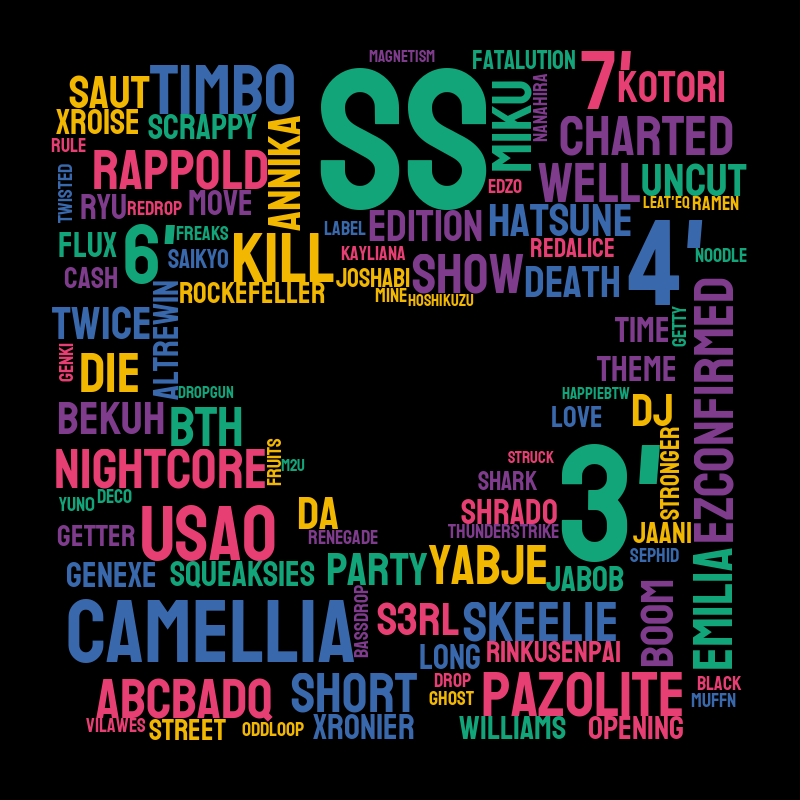

In [63]:
#@title Latest History Wordcloud
width =  800 #param {type:"number"}
height =  800#param {type:"number"}
max_words =  100#@param {type:"number"}
background_color = "black" #param ["black", "white"]
wordcloud_target = "All(-Tags)" #@param ["All(-Tags)","Level","LevelAuthor", "SongAuthor", "Level&SongAuthor", "Song", "Tags", "All"]
color_map= "bwr" #['inferno', 'magma', 'plasma', 'viridis','Blues', 'BuGn', 'BuPu', 'GnBu','Greens', 'Greys', 'OrRd', 'Oranges','PuBu', 'PuBuGn', 'PuRd', 'Purples','RdPu', 'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd','binary', 'gist_yarg', 'gist_gray', 'gray','bone', 'pink', 'spring', 'summer','autumn', 'winter', 'cool', 'Wistia','hot', 'afmhot', 'gist_heat', 'copper','PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu','RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic','Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2','Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c','flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'gnuplot','gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv', 'gist_rainbow', 'rainbow','jet', 'nipy_spectral', 'gist_ncar']
wordcloud_style= "random-icon-style"  #@param["normal","random-icon-style"]
filtered_level_min = 0 #@param {type:"slider", min:0, max:15, step:1}
filtered_level_max = 15 #@param {type:"slider", min:0, max:15, step:1}
filtered_pp_min = 0 #@param {type:"slider", min:0, max:600, step:10}
filtered_pp_max = 600 #@param {type:"slider", min:0, max:600, step:10}
filtered_acc_min = 0 #@param {type:"slider", min:0, max:100, step:1}
filtered_acc_max = 100 #@param {type:"slider", min:0, max:100, step:1}
filtered_latest_is_enable = True #@param {type:"boolean"}
filtered_ranked_is_enable = True #@param {type:"boolean"}
filtered_fullcombo_is_enable = False #param {type:"boolean"}

wc_icons = [
         'fas fa-bomb',
         'fas fa-caret-square-down',
         'fas fa-caret-square-left',
         'fas fa-caret-square-right',
         'fas fa-caret-square-up',
         'fas fa-certificate',
         'fas fa-clone',
         'fas fa-circle',
         'fas fa-dice-d6',
         'fas fa-dice-one',
]

# colormap参考記事
# https://karupoimou.hatenablog.com/entry/2019/05/17/153207

df_wordcloud = df_scores.copy()

if filtered_latest_is_enable:
    df_wordcloud = df_wordcloud[(df_wordcloud["Latest"] == 1)]

if filtered_ranked_is_enable:
    df_wordcloud = df_wordcloud[(df_wordcloud['Ranked']==1)]
    df_wordcloud = df_wordcloud[(1==1)
        & (df_wordcloud["Stars"] >= filtered_level_min)
        & (df_wordcloud["Stars"] < filtered_level_max)
        & (df_wordcloud["PP"] >= filtered_pp_min)
        & (df_wordcloud["PP"] < filtered_pp_max)
        & (df_wordcloud["Acc"] >= filtered_acc_min)
        & (df_wordcloud["Acc"] <= filtered_acc_max)]

if filtered_fullcombo_is_enable:
    df_wordcloud = df_wordcloud[(df_wordcloud['FC']=="FC")]

def func_level_to_star(x):
    return x + "'"

df_wordcloud['LevelStr'] = df_wordcloud['LevelStr'].apply(func_level_to_star)

STOPWORDS.add("feat")
STOPWORDS.add("ft")
STOPWORDS.add("Remix")
STOPWORDS.add("original")
STOPWORDS.add("TV")
STOPWORDS.add("Size")
STOPWORDS.add("feat")
STOPWORDS.add("Ver")
STOPWORDS.add("Mix")
STOPWORDS.add("VS")
STOPWORDS.add("Video")
STOPWORDS.add("Game")
STOPWORDS.add("Movie")

def create_style_wordcloud(text):
    import random
    wc_icon = random.choice(wc_icons)

    stylecloud.gen_stylecloud(text=text,
                            icon_name =wc_icon,
                            palette="cartocolors.qualitative.Bold_5",
                            background_color='black',
                            random_state=True,
                            max_words=max_words,
                            collocations = False,
                            size=(width, height)
                            )

def create_wordcloud(text):
    font_path_gothic = '/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf'
    wordcloud = WordCloud(background_color=background_color, max_words=max_words, 
                          width=width, height=height,
                          collocations = False, colormap=color_map
                          ).generate(text)
    plt.figure(figsize=(15,15))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("History WordCloud - {} - {}".format(tz_ja.strftime("%Y.%m.%d"), df_info["name"][0]))
    plt.show()

if len(df_wordcloud) > 0:

    if wordcloud_target == "LevelAuthor":
        list_levelauthor = df_wordcloud["LevelAuthor"].tolist()
        wc_text = " ".join(list_levelauthor)
    elif wordcloud_target == "SongAuthor":
        list_songauthor = df_wordcloud["SongAuthor"].tolist()
        wc_text = " ".join(list_songauthor)
    elif wordcloud_target == "Level&SongAuthor":
        list_levelauthor = df_wordcloud["LevelAuthor"].tolist()
        list_songauthor = df_wordcloud["SongAuthor"].tolist()
        list_merge = copy.copy(list_songauthor)
        list_merge.extend(list_levelauthor)
        wc_text = " ".join(list_merge)
    elif wordcloud_target == "Tags":
        list_tags = df_wordcloud["Tags"].dropna().tolist()
        wc_text = " ".join(list_tags)
    elif wordcloud_target == "Song":
        list_song = df_wordcloud["Song"].tolist()
        wc_text = " ".join(list_song)

    elif wordcloud_target == "Level":
        list_acc = df_wordcloud["AccRank"].dropna().tolist()
        list_level = df_wordcloud["LevelStr"].dropna().tolist()
        list_merge = copy.copy(list_acc)
        list_merge.extend(list_level)
        wc_text = " ".join(list_merge)

    elif (wordcloud_target == "All") or (wordcloud_target == "All(-Tags)"):
        list_song = df_wordcloud["Song"].tolist()
        list_acc = df_wordcloud["AccRank"].dropna().tolist()
        list_level = df_wordcloud["LevelStr"].dropna().tolist()
        list_merge = copy.copy(list_song)
        if wordcloud_target == "All":
            list_tags = df_wordcloud["Tags"].dropna().tolist()
            list_merge.extend(list_tags)
        list_merge.extend(list_acc)
        list_merge.extend(list_level)
        wc_text = " ".join(list_merge)

    if wordcloud_style == "random-icon-style":
        create_style_wordcloud(wc_text)
        from IPython.display import Image
        display(Image(filename="./stylecloud.png", width=width, height=height))
    else:
        create_wordcloud(wc_text)
else:
    print("データ件数が0件のため WordCloud が作成できません。フィルタ条件を緩和してください。")